### Initialise Experimental System

In [1]:
# Import python libraries

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Define circuit parameters 

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001 * 2 * np.pi   # Qubit decay (1 MHz) [self-defined, not from reference]
gamma_2 = 0.001 * 2 * np.pi   # Qubit dephase (1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - g * (a + a.dag()) * (q + q.dag())  # Dispersive Hamiltonian
# H0 = wq_d * sz/2 + wr_d * a.dag() * a - chi * a.dag() * a * sz  # Dispersive Hamiltonian

# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - chi * (q.dag()*q) * (a.dag()*a)  # Dispersive Hamiltonian

H0 = (wr - wd + chi * sz) * a.dag() * a + (wq -wd)/2 * sz
drive_power = 4.984375000000001e-05 * 2 * np.pi

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns


In [3]:
def find_drive_power(target_photon_number, tolerance=0.01):
    """Find the drive power needed to inject a specific photon number into the resonator."""
    power = 0.00004 * 2 * np.pi
    step = 0.0001 * 2 * np.pi  # Initial step size for power
    while True:
        HD = np.sqrt(power) * (a + a.dag())
        H = H0 + HD
        # Calculate the steady state
        steady_state = steadystate(H, c_ops=c_ops)
        n_expt = expect(a.dag() * a, steady_state)
        q_expt = expect(q.dag() * q, steady_state)
        print(f"Steady state photon number: {n_expt:.2f}, with drive power: {power / (2 * np.pi):.5f} GHz")

        if abs(n_expt - target_photon_number) < tolerance:
            break
        
        if n_expt < target_photon_number:
            power += step  # Increase power if we need more photons
        else:
            power -= step  # Decrease power if we have too many photons
        
        step /= 2  # Reduce step size for finer tuning
    
    return power, q_expt

# Find the drive power to inject 1 photon into the resonator
target_photon_number = 1
drive_power, qubit_state = find_drive_power(target_photon_number)
print(f"Drive power needed to inject {target_photon_number} photon(s): {drive_power / (2 * np.pi)} GHz")
print (f"Qubit state expectation value: {qubit_state}")


Steady state photon number: 0.81, with drive power: 0.00004 GHz
Steady state photon number: 2.82, with drive power: 0.00014 GHz
Steady state photon number: 1.82, with drive power: 0.00009 GHz
Steady state photon number: 1.31, with drive power: 0.00007 GHz
Steady state photon number: 1.06, with drive power: 0.00005 GHz
Steady state photon number: 0.93, with drive power: 0.00005 GHz
Steady state photon number: 1.00, with drive power: 0.00005 GHz
Drive power needed to inject 1 photon(s): 4.937500000000001e-05 GHz
Qubit state expectation value: 0.0


### Simulation of System Dynamics

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


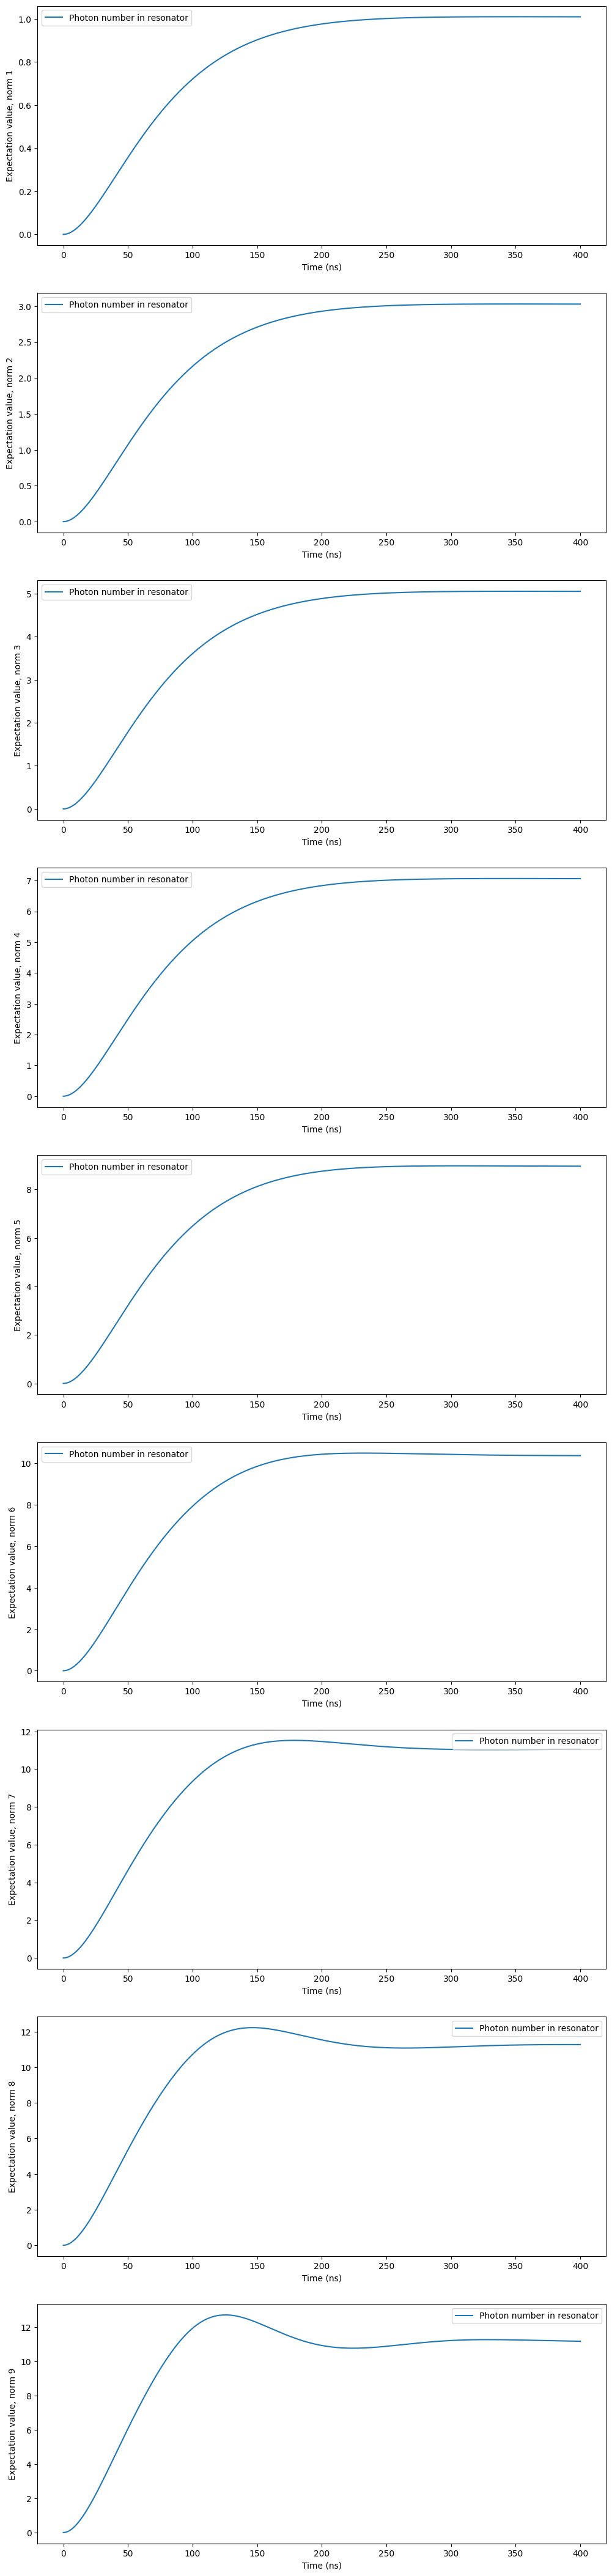

In [5]:
# Explore effects of different drive powers on the system
drive_power = 5e-05 * 2 * np.pi
norm = 1
N_plots = 10
plt.figure(figsize=(12, 60))

for i in range(1, N_plots):
    HD = np.sqrt(norm*drive_power) * (a + a.dag())
    H = H0 + HD
    tlist = np.linspace(0, 400, 2000)  # Time from 0 to 800 ns

    # Calculate the steady state
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    norm += 2

    plt.subplot(N_plots, 1, i)
    plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
    plt.xlabel('Time (ns)')
    plt.ylabel(f'Expectation value, norm {i}')
    plt.legend()


In [16]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-3, window_size=500):
    photon_number = np.array(photon_number)
    tlist = np.array(tlist)

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]
    
    return None

def find_cavity_reset_time(tlist, photon_number, threshold=1e-3, stable_time=50):
    offset = 5000
    photon_number = np.array(photon_number[offset:])
    tlist = np.array(tlist[offset:])

    dt = tlist[1] - tlist[0]
    stable_points = int(np.ceil(stable_time / dt))

    below = photon_number <= threshold

    i = 0
    while i <= len(below) - stable_points:
        if below[i]:
            window = below[i : i + stable_points]
            if np.all(window):
                return tlist[i] - 500  # Adjust based on original intent
            else:
                # Skip ahead to end of unstable segment
                first_fail = np.argmax(~window)  # Index of first False in the window
                i += first_fail + 1  # Move to next candidate index
        else:
            i += 1  # Keep scanning

    return np.inf  # No stable period found

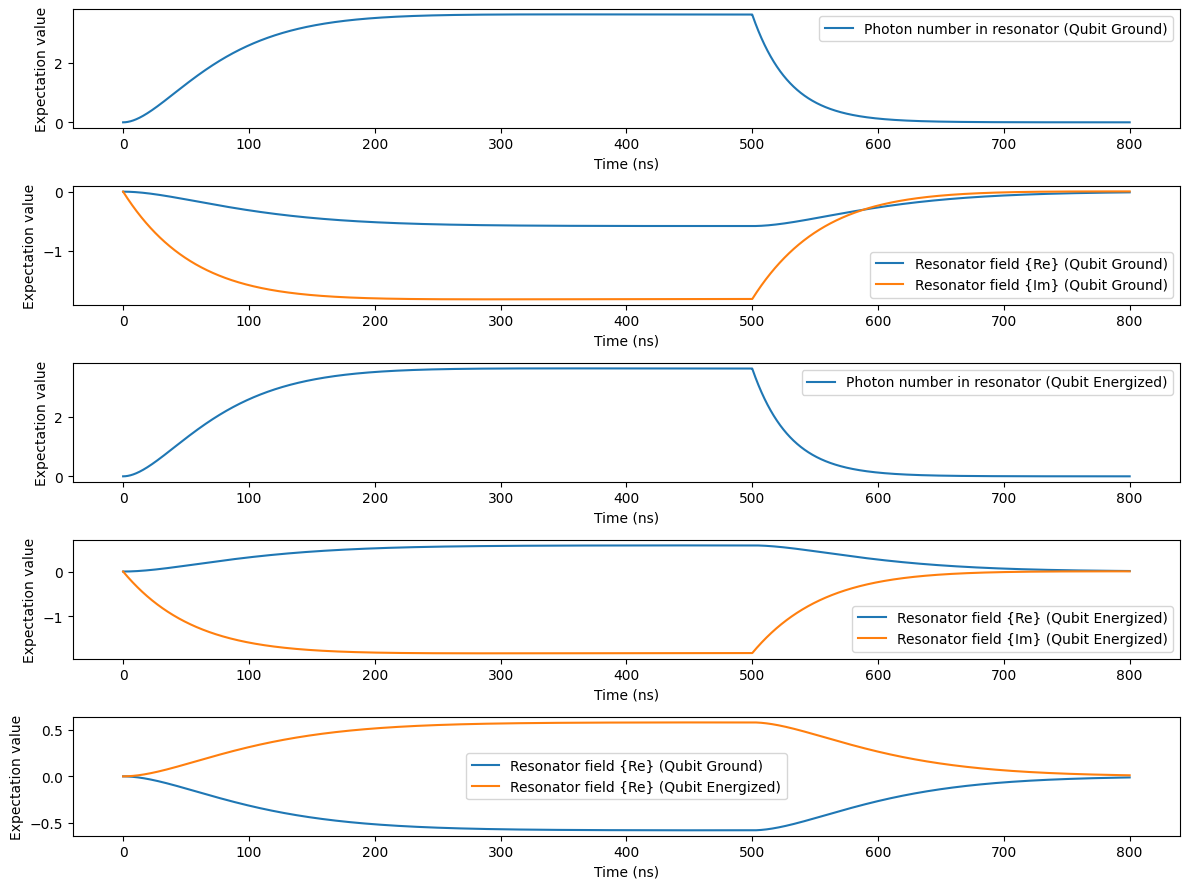

In [7]:
# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000) 
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(5, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values_g[0])
reset_time = find_cavity_reset_time(tlist, expectation_values_g[0])
print(f"Rectangle Pulse Steady state duration: {steady_state_time} ns")
print(f"Rectangle Pulse Cavity reset duration: {reset_time} ns")

Rectangle Pulse Steady state duration: 321.44018002250283 ns
Rectangle Pulse Cavity reset duration: 243.89298662332794 ns


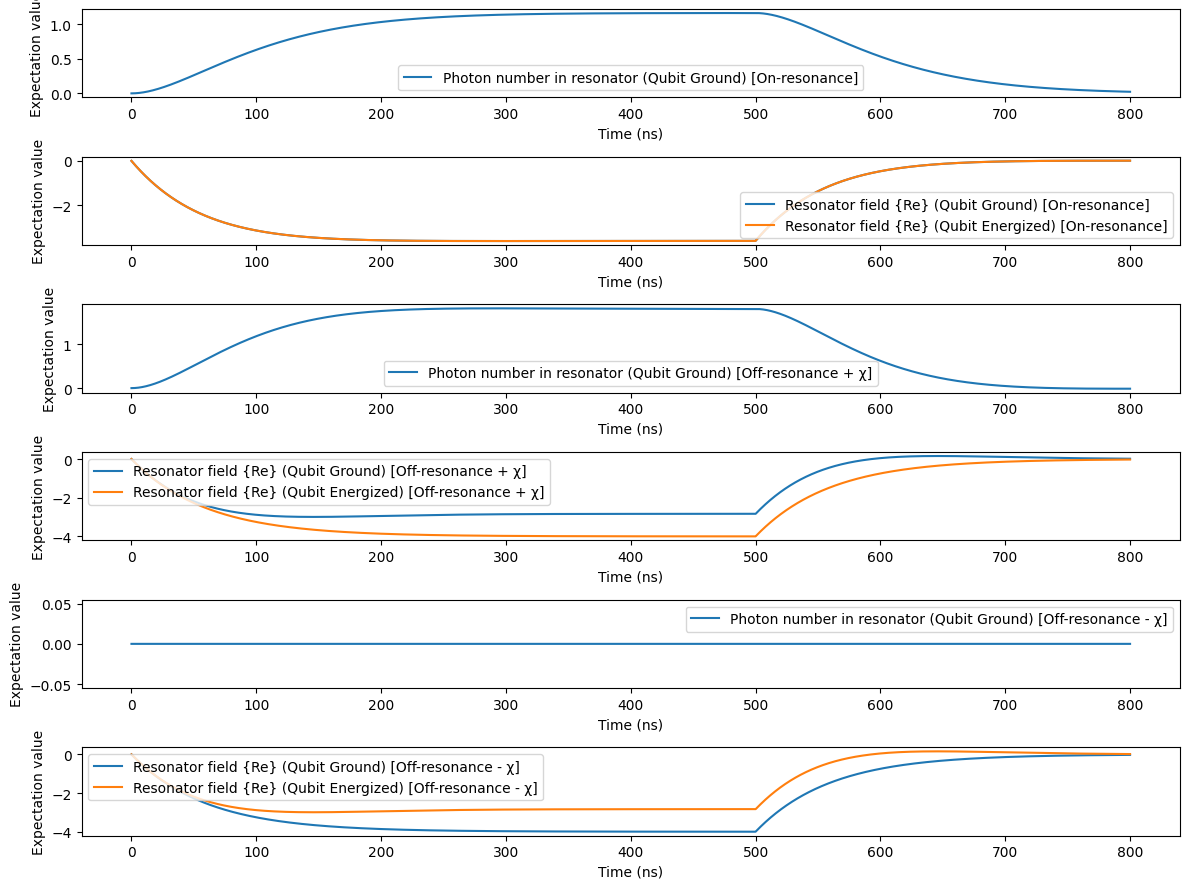

In [24]:
# Testing the resonator field with different drive frequencies (off-resonance shifted by chi)

wd = wr
H0 = (wr - wd - chi * sz) * a.dag() * a + wq/2 * sz

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g_res = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_res = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_res = [expectations_g_res.expect[i] for i in range(len(e_ops))]
expectation_values_e_res = [expectations_e_res.expect[i] for i in range(len(e_ops))]


wd = wr + chi
H0 = (wr - wd - chi * sz) * a.dag() * a
H = [H0, HD]
expectations_g_plus = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_plus = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_plus = [expectations_g_plus.expect[i] for i in range(len(e_ops))]
expectation_values_e_plus = [expectations_e_plus.expect[i] for i in range(len(e_ops))]


wd = wr - chi
H0 = (wr - wd - chi * sz) * a.dag() * a
H = [H0, HD]
expectations_g_minus = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_minus = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_minus = [expectations_g_minus.expect[i] for i in range(len(e_ops))]
expectation_values_e_minus = [expectations_e_minus.expect[i] for i in range(len(e_ops))]


# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(6, 1, 1)
plt.plot(tlist, expectation_values_g_res[0], label='Photon number in resonator (Qubit Ground) [On-resonance]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(tlist, np.real(expectation_values_g_res[1]), label='Resonator field {Re} (Qubit Ground) [On-resonance]')
plt.plot(tlist, np.real(expectation_values_e_res[1]), label='Resonator field {Re} (Qubit Energized) [On-resonance]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(tlist, expectation_values_g_plus[0], label='Photon number in resonator (Qubit Ground) [Off-resonance + χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 4)    
plt.plot(tlist, np.real(expectation_values_g_plus[1]), label='Resonator field {Re} (Qubit Ground) [Off-resonance + χ]')
plt.plot(tlist, np.real(expectation_values_e_plus[1]), label='Resonator field {Re} (Qubit Energized) [Off-resonance + χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(tlist, expectation_values_g_minus[0], label='Photon number in resonator (Qubit Ground) [Off-resonance - χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(tlist, np.real(expectation_values_g_minus[1]), label='Resonator field {Re} (Qubit Ground) [Off-resonance - χ]')
plt.plot(tlist, np.real(expectation_values_e_minus[1]), label='Resonator field {Re} (Qubit Energized) [Off-resonance - χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()    

plt.tight_layout()
plt.show()

Steady state is close to coherent state for Ground Qubit: True
Steady state is close to coherent state for Excited Qubit: True
Steady state is close to coherent state for Superposition Qubit: False


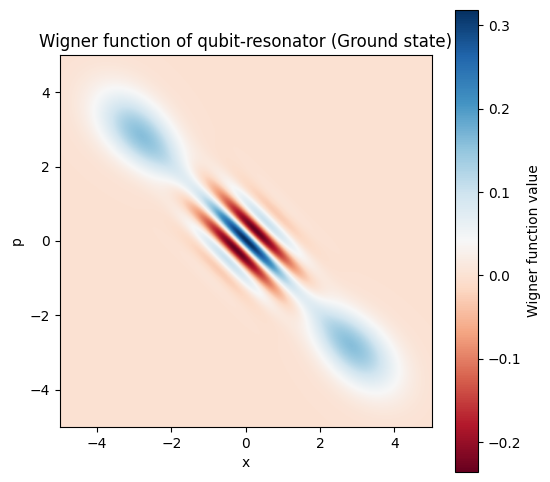

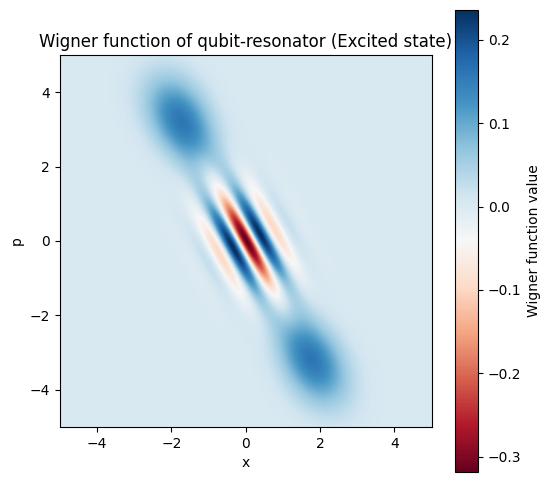

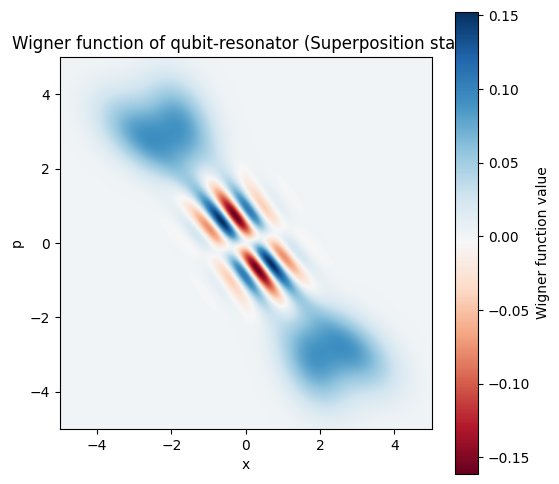

In [10]:
# Explore the steady state of the resonator field for different qubit states

norm = 3.6
drive_amp = np.sqrt(norm * drive_power) 
HD = drive_amp *(a + a.dag())
H = H0 + HD

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000) 
states_g = mesolve(H, psi0, tlist, c_ops)
states_e = mesolve(H, psi1, tlist, c_ops)
states_s = mesolve(H, psis, tlist, c_ops)

xvec = np.linspace(-5, 5, 500)

expect_a_g = expect(a, states_g.states[-1])
expect_n_g = expect((a.dag() * a), states_g.states[-1])
is_close_g = np.isclose(abs(expect_a_g)**2, expect_n_g)
print("Steady state is close to coherent state for Ground Qubit:", is_close_g)

expect_a_e = expect(a, states_e.states[-1])
expect_n_e = expect((a.dag() * a), states_e.states[-1])
is_close_e = np.isclose(abs(expect_a_e)**2, expect_n_e)
print("Steady state is close to coherent state for Excited Qubit:", is_close_e)

expect_a_s = expect(a, states_s.states[-1])
expect_n_s = expect((a.dag() * a), states_s.states[-1])
is_close_s = np.isclose(abs(expect_a_s)**2, expect_n_s)
print("Steady state is close to coherent state for Superposition Qubit:", is_close_s)

W_g = wigner(states_g.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_g, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Ground state)")
plt.xlabel('x')
plt.ylabel('p') 

W_e = wigner(states_e.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_e, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Excited state)")
plt.xlabel('x')
plt.ylabel('p')

W_s = wigner(states_s.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_s, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Superposition state)")
plt.xlabel('x')
plt.ylabel('p') 

plt.show()

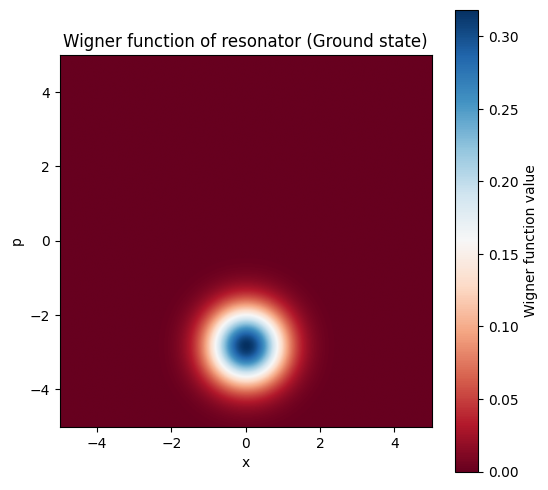

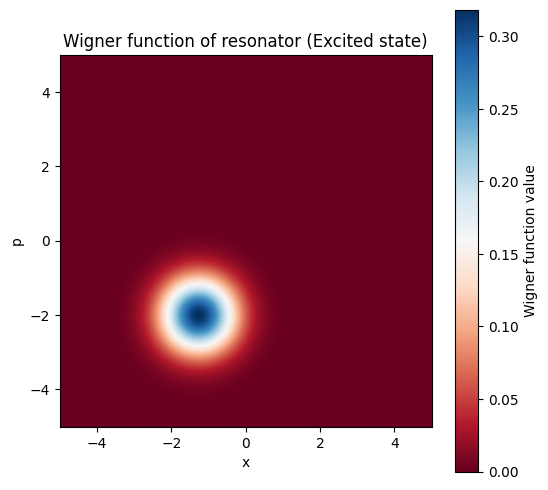

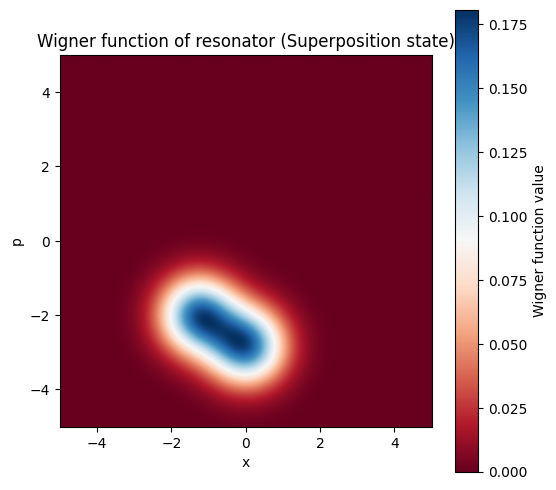

In [11]:
state_res_g = states_g.states[-1].ptrace(0)
state_res_e = states_e.states[-1].ptrace(0)
state_res_s = states_s.states[-1].ptrace(0)

xvec = np.linspace(-5, 5, 500)

W_g = wigner(state_res_g, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_g, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Ground state)")
plt.xlabel('x')
plt.ylabel('p') 

W_e = wigner(state_res_e, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_e, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Excited state)")
plt.xlabel('x')
plt.ylabel('p')

W_s = wigner(state_res_s, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_s, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Superposition state)")
plt.xlabel('x')
plt.ylabel('p') 

plt.show()

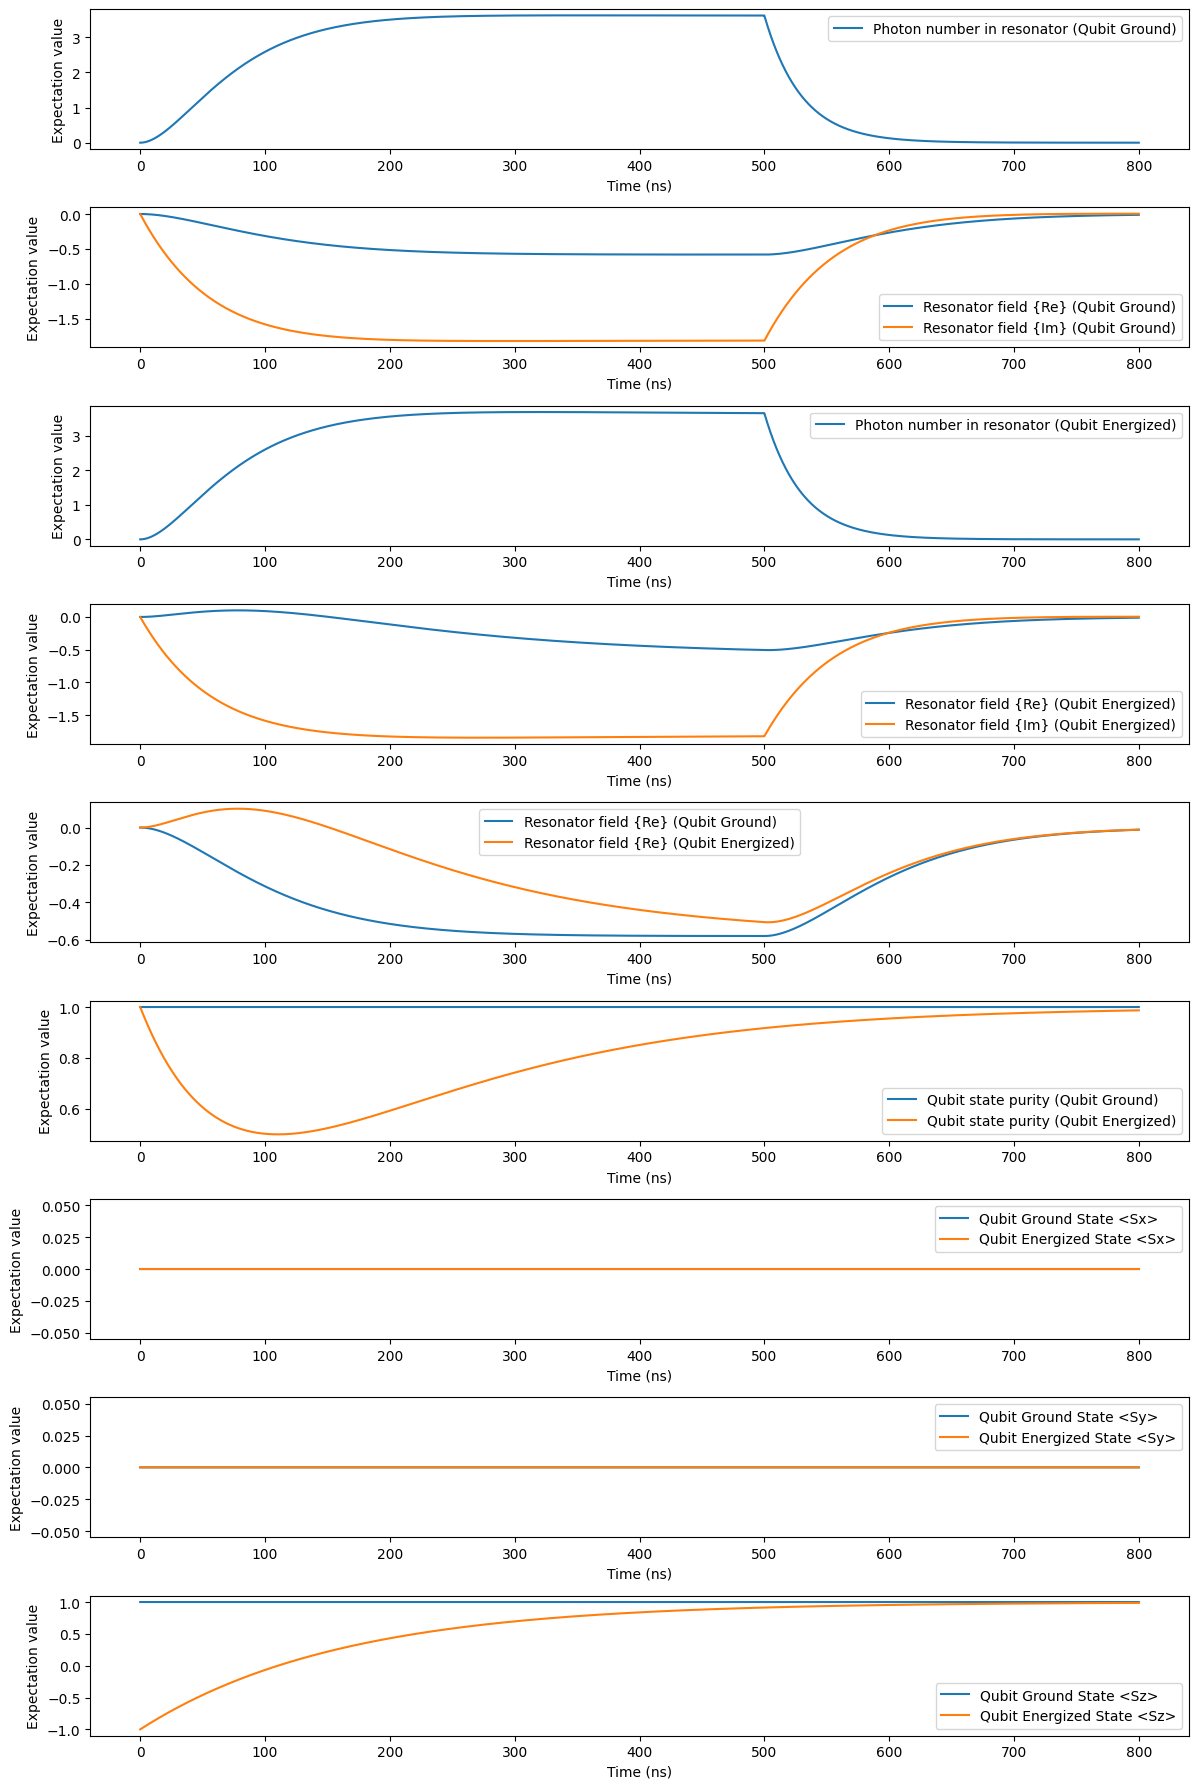

In [14]:
# Factor in effects of qubit relaxation

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H, psi0, tlist, c_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops)

# Extract the expectation values
expectation_values_g = expect(e_ops,expectations_g.states)
expectation_values_e = expect(e_ops,expectations_e.states)

rho_q_g = [state.ptrace(1).purity() for state in expectations_g.states]
rho_q_e = [state.ptrace(1).purity() for state in expectations_e.states]

sx_g, sy_g, sz_g = expect([sx, sy, sz], expectations_g.states)
sx_e, sy_e, sz_e = expect([sx, sy, sz], expectations_e.states)

# Plot the results
plt.figure(figsize=(12, 18))

plt.subplot(9, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 6)
plt.plot(tlist, rho_q_g, label='Qubit state purity (Qubit Ground)')
plt.plot(tlist, rho_q_e, label='Qubit state purity (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 7)
plt.plot(tlist, sx_g, label='Qubit Ground State <Sx>')
plt.plot(tlist, sx_e, label='Qubit Energized State <Sx>')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 8)
plt.plot(tlist, sy_g, label='Qubit Ground State <Sy>')
plt.plot(tlist, sy_e, label='Qubit Energized State <Sy>')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(9, 1, 9)
plt.plot(tlist, sz_g, label='Qubit Ground State <Sz>')
plt.plot(tlist, sz_e, label='Qubit Energized State <Sz>')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()


plt.tight_layout()
plt.show()

10.0%. Run time:   3.23s. Est. time left: 00:00:00:29
20.0%. Run time:   7.21s. Est. time left: 00:00:00:28
30.0%. Run time:  11.38s. Est. time left: 00:00:00:26
40.0%. Run time:  15.45s. Est. time left: 00:00:00:23
50.0%. Run time:  19.56s. Est. time left: 00:00:00:19
60.0%. Run time:  23.60s. Est. time left: 00:00:00:15
70.0%. Run time:  27.58s. Est. time left: 00:00:00:11
80.0%. Run time:  31.56s. Est. time left: 00:00:00:07
90.0%. Run time:  35.57s. Est. time left: 00:00:00:03
100.0%. Run time:  39.55s. Est. time left: 00:00:00:00
Total run time:  40.35s
10.0%. Run time:   3.32s. Est. time left: 00:00:00:29
20.0%. Run time:   7.38s. Est. time left: 00:00:00:29
30.0%. Run time:  11.41s. Est. time left: 00:00:00:26
40.0%. Run time:  15.35s. Est. time left: 00:00:00:23
50.0%. Run time:  19.40s. Est. time left: 00:00:00:19
60.0%. Run time:  23.39s. Est. time left: 00:00:00:15
70.0%. Run time:  27.38s. Est. time left: 00:00:00:11
80.0%. Run time:  31.38s. Est. time left: 00:00:00:07
90.

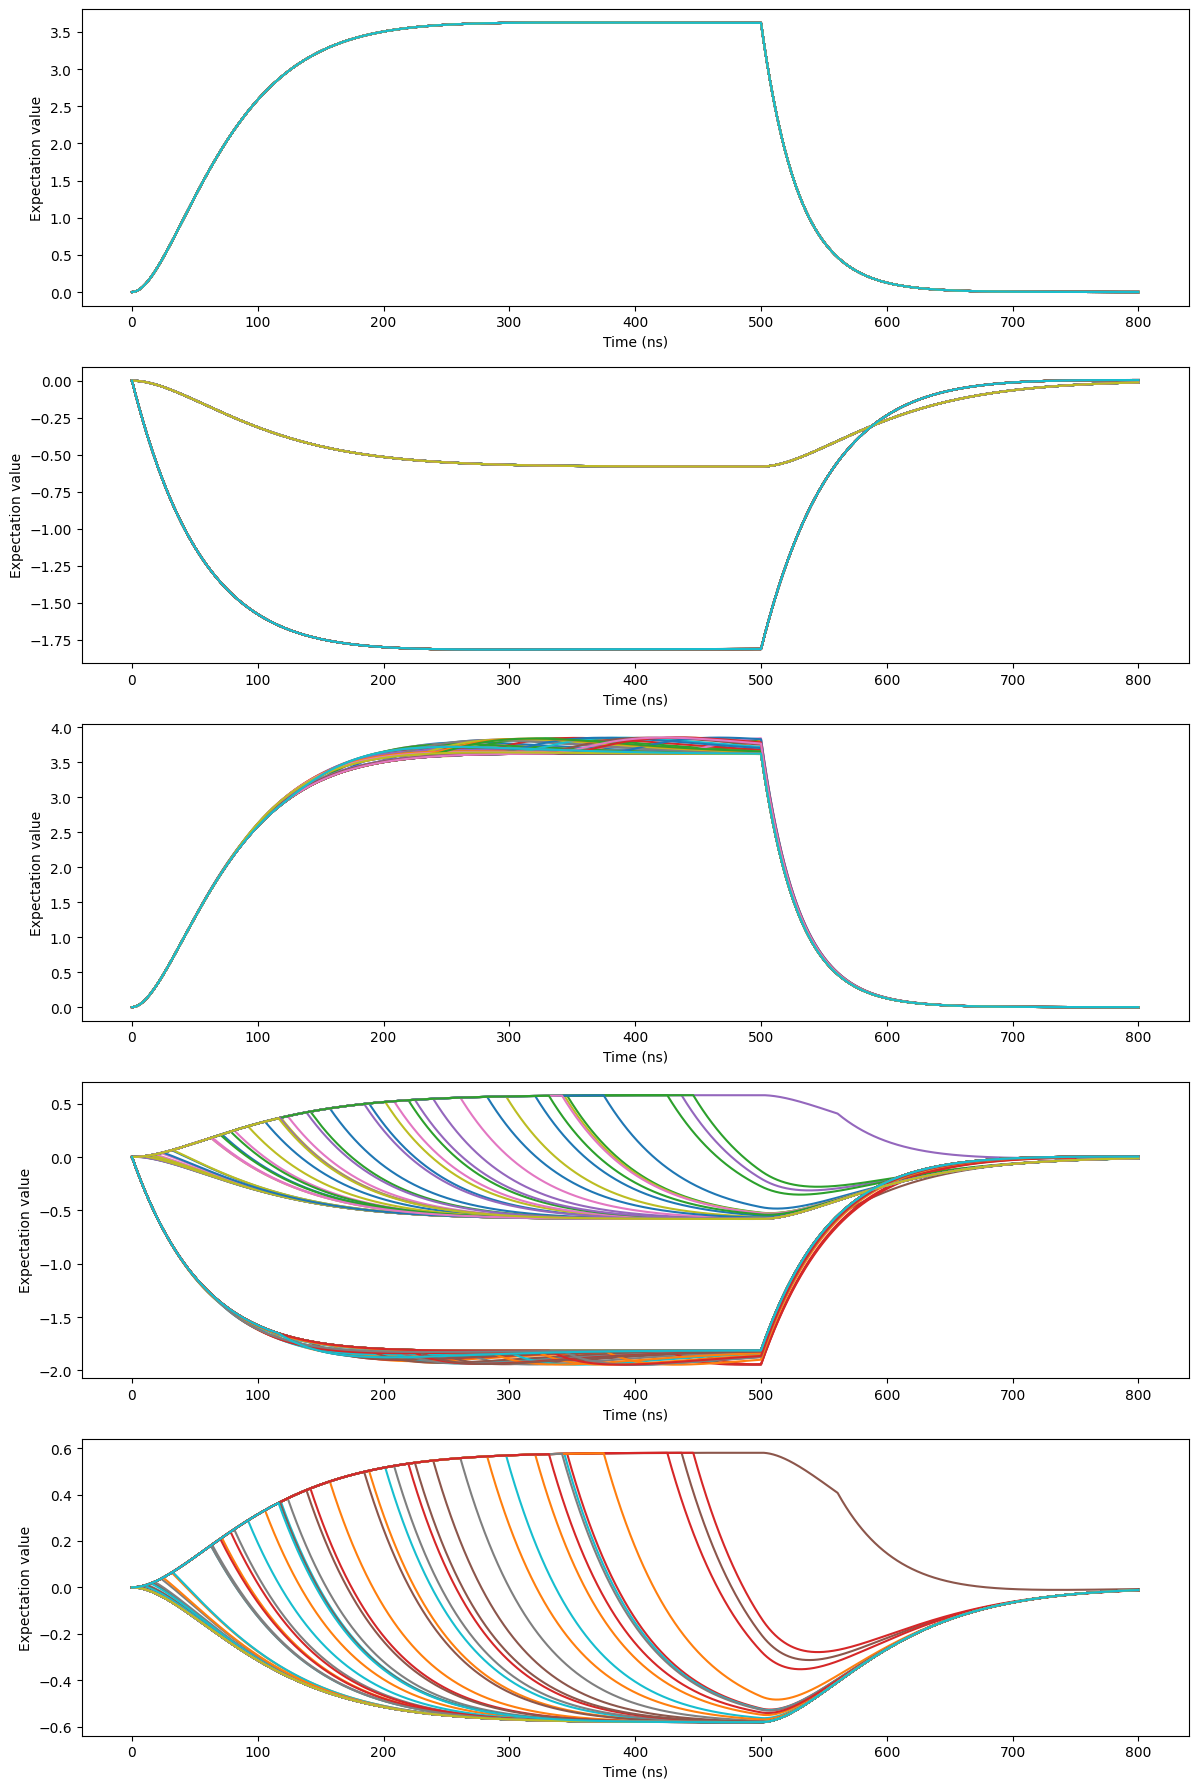

In [15]:
# Test with Monte Carlo solver to simulate the system with different trajectories

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]
P0 = basis(2, 0) * basis(2, 0).dag()
P1 = basis(2, 1) * basis(2, 1).dag()
sz_dephase = tensor(qeye(N),(P1 - P0))

e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * sz, np.sqrt(gamma_1) * q]  # Resonator decay and qubit decay

tlist = np.linspace(0, 800, 8000)
ntrajs = 50
runs_g = mcsolve(H=H, state=psi0, tlist=tlist, c_ops=c_ops, e_ops=e_ops, ntraj=ntrajs, options={'keep_runs_results':True})
runs_e = mcsolve(H=H, state=psi1, tlist=tlist, c_ops=c_ops, e_ops=e_ops, ntraj=ntrajs, options={'keep_runs_results':True})
# Plot the results
plt.figure(figsize=(12, 18))

plt.subplot(5, 1, 1)
for k in range(ntrajs):
    plt.plot(tlist, runs_g.runs_expect[0][k])
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')

plt.subplot(5, 1, 2)
for k in range(ntrajs):
    plt.plot(tlist, np.real(runs_g.runs_expect[1][k]))
    plt.plot(tlist, np.imag(runs_g.runs_expect[1][k]))
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')

plt.subplot(5, 1, 3)
for k in range(ntrajs):
    plt.plot(tlist, runs_e.runs_expect[0][k])
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')

plt.subplot(5, 1, 4)
for k in range(ntrajs):
    plt.plot(tlist, np.real(runs_e.runs_expect[1][k]))
    plt.plot(tlist, np.imag(runs_e.runs_expect[1][k]))
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')

plt.subplot(5, 1, 5)
for k in range(ntrajs):
    plt.plot(tlist, np.real(runs_g.runs_expect[1][k]))
    plt.plot(tlist, np.real(runs_e.runs_expect[1][k]))
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')

plt.tight_layout()
plt.show()

### Pulse Optimisation

In [ ]:
# Define simulate functions for optimizing the ring-up and ring-down sequences

def simulate_populate(ringup_time, ringdown_time, ringup_norm, ringdown_norm):
    drive_norm = 3.6
    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse(t, args):
        if t<=ringup_time:
            return ringup_amp
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp
        elif t <= 500:
            return drive_amp
        else:   
            return 0.0
        
    HD = [(a + a.dag()), drive_pulse]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

def simulate_reset(ringup_time, ringdown_time, ringup_norm, ringdown_norm):
    drive_norm = 3.6

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_rst(t, args):
        if t<=500:
            return drive_amp 
        elif t <= 500 + ringdown_time:
            return ringdown_amp
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp
        else:   
            return 0.0
        
    HD = [(a + a.dag()), drive_pulse_rst]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

Optimal ring-up time: 65 ns, ring-down time: 26 ns, ring-up norm: 9, ring-down norm: 1.5 stabilization time: 246.530816352044 ns


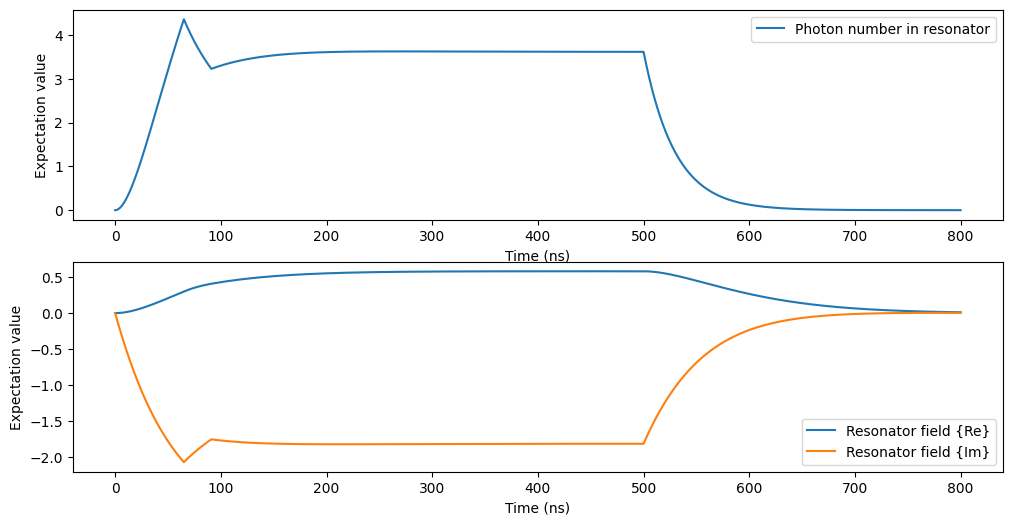

In [ ]:
# Optimise the ringup and ringdown times to arrive the fastest at steady state
ringup_times = np.arange(50, 70, 5) 
ringdown_times = np.arange(20, 30, 2)
ringup_norms = np.arange(4, 10, 1)  
ringdown_norms = np.arange(1, 3, 0.5)  
stabilization_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:
        for ringup_norm in ringup_norms:
            for ringdown_norm in ringdown_norms:
                # Extract the expectation values
                expectation_values = simulate_populate(ringup, ringdown, ringup_norm, ringdown_norm)
                # settling_time, overshoot, steady_val = analyze_response(tlist, expectation_values[0])
                # cost = compute_cost(settling_time, overshoot)
                # Find stabilization time
                stabilization_time = find_steady_state_time(tlist, expectation_values[0])
                stabilization_times.append((ringup, ringdown, ringup_norm, ringdown_norm, stabilization_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(stabilization_times, key=lambda x: (x[4] is not None, x[4]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, ring-up norm: {optimal[2]}, ring-down norm: {optimal[3]} stabilization time: {optimal[4]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[5]
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

Optimal ring-up time: 25 ns, ring-down time: 35 ns, ring-up norm: 1.0, ring-down norm: 9 reset time: 178.98487310913868 ns


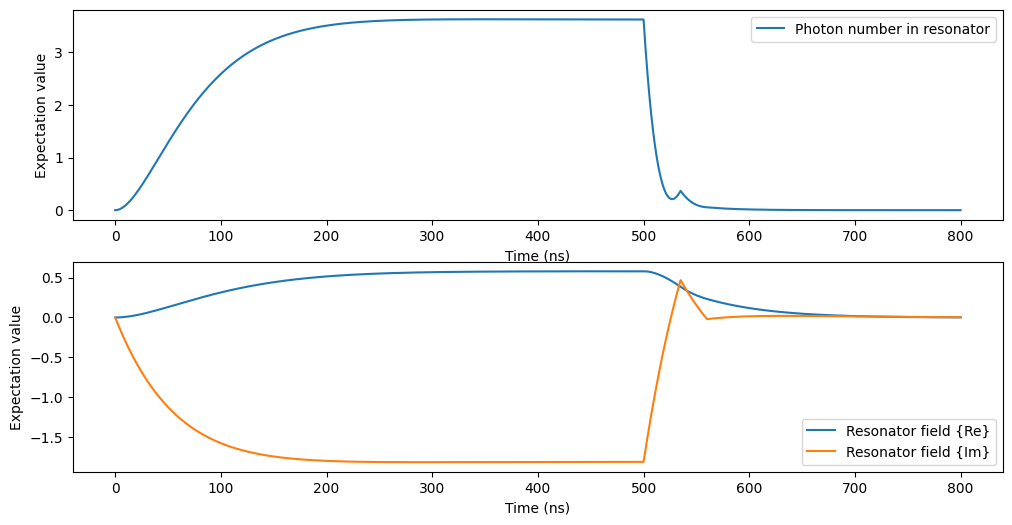

In [34]:
# Optimise the ringup and ringdown times to reset cavity fastest
ringup_times = np.arange(5, 40, 5)  
ringdown_times = np.arange(5, 40, 5)
ringup_norms = np.arange(1, 3, 0.5)  
ringdown_norms = np.arange(4, 10, 1) 
reset_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:
        for ringup_norm in ringup_norms:
            for ringdown_norm in ringdown_norms:
                # Extract the expectation values
                expectation_values = simulate_reset(ringup, ringdown, ringup_norm, ringdown_norm)

                # Find stabilization time
                reset_time = find_cavity_reset_time(tlist, expectation_values[0])
                reset_times.append((ringup, ringdown, ringup_norm, ringdown_norm, reset_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(reset_times, key=lambda x: (x[4] is not None, x[4]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, ring-up norm: {optimal[2]}, ring-down norm: {optimal[3]} reset time: {optimal[4]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[5]
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

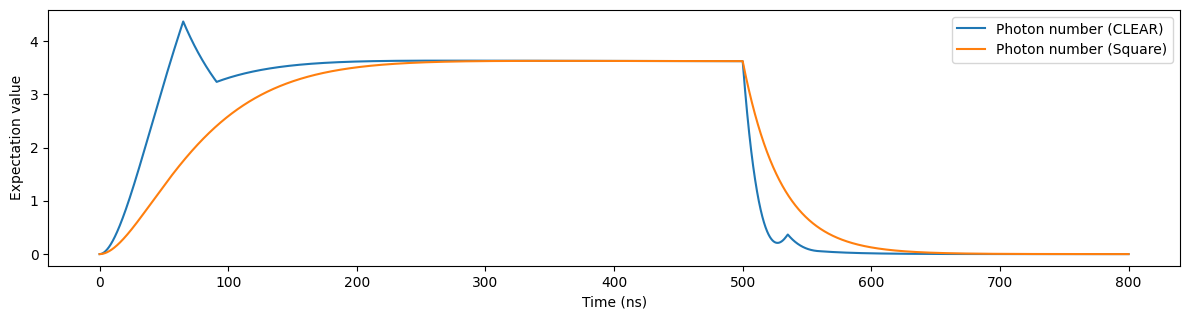

In [33]:
# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 9
ringdown1_norm = 1.5
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 1
drive_norm = 3.6
ringdown2_norm = 9
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 65
optimal_ringdown1_time = 26
optimal_ringup2_time = 25
optimal_ringdown2_time = 35


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp 
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp 
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:   
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square = mesolve(H_drive, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR = [expectations_CLEAR.expect[i] for i in range(len(e_ops))]
expectation_values_square = [expectations_square.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values_CLEAR[0], label='Photon number (CLEAR)')
plt.plot(tlist, expectation_values_square[0], label='Photon number (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

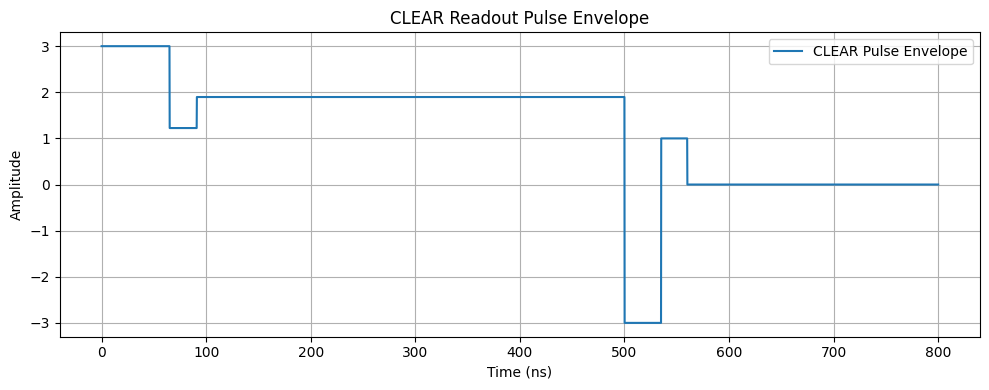

In [ ]:
# Plot the CLEAR pulse envelope

envelope = [CLEAR_pulse(t, None) / np.sqrt(drive_power) for t in tlist]
plt.figure(figsize=(10, 4))
plt.plot(tlist, envelope, label='CLEAR Pulse Envelope')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("CLEAR Readout Pulse Envelope")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Determine steady state time and reset time for a CLEAR pulse
steady_state_time_CLEAR = find_steady_state_time(tlist, expectation_values_CLEAR[0])
reset_time_CLEAR = find_cavity_reset_time(tlist, expectation_values_CLEAR[0])
print(f"CLEAR Pulse Steady state duration: {steady_state_time_CLEAR} ns")
print(f"CLEAR Pulse Cavity reset duration: {reset_time_CLEAR} ns")

# Determine steady state time and reset time for a rectangle pulse
steady_state_time_square = find_steady_state_time(tlist, expectation_values_square[0])
reset_time_square = find_cavity_reset_time(tlist, expectation_values_square[0])
print(f"Square Pulse Steady state duration: {steady_state_time_square} ns") 
print(f"Square Pulse Cavity reset duration: {reset_time_square} ns")

CLEAR Pulse Steady state duration: 246.530816352044 ns
CLEAR Pulse Cavity reset duration: 178.98487310913868 ns
Square Pulse Steady state duration: 321.44018002250283 ns
Square Pulse Cavity reset duration: 243.79297412176527 ns


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


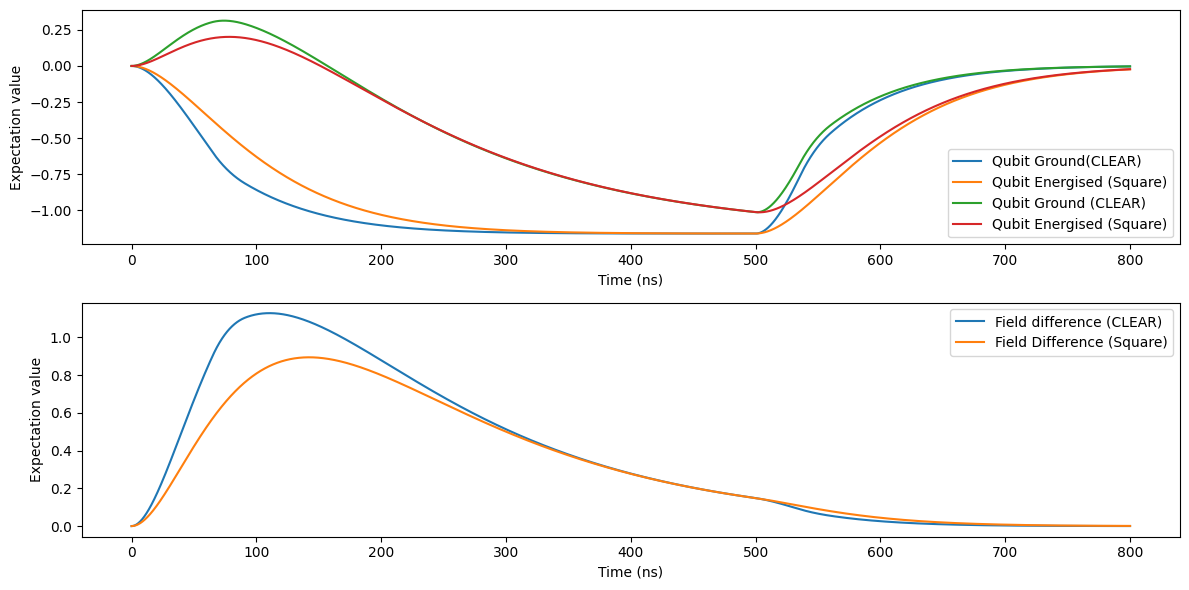

In [108]:
e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay

#Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR_g = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_CLEAR_e = mesolve(H_CLEAR, psi1, tlist, c_ops, e_ops)
expectations_square_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR_g = [expectations_CLEAR_g.expect[i] for i in range(len(e_ops))]
expectation_values_square_g = [expectations_square_g.expect[i] for i in range(len(e_ops))]
expectation_values_CLEAR_e = [expectations_CLEAR_e.expect[i] for i in range(len(e_ops))]
expectation_values_square_e = [expectations_square_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values_CLEAR_g[0], label='Qubit Ground(CLEAR)')
plt.plot(tlist, expectation_values_square_g[0], label='Qubit Energised (Square)')
plt.plot(tlist, expectation_values_CLEAR_e[0], label='Qubit Ground (CLEAR)')
plt.plot(tlist, expectation_values_square_e[0], label='Qubit Energised (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, abs(expectation_values_CLEAR_g[0] - expectation_values_CLEAR_e[0]), label='Field difference (CLEAR)')
plt.plot(tlist, abs(expectation_values_square_g[0] - expectation_values_square_e[0]), label='Field Difference (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

### Simulating the IQ response to readout pulse

In [7]:
# Define circuit parameters 

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001 * 2 * np.pi   # Qubit decay (0.1 MHz) [self-defined, not from reference]
gamma_2 = 0.001 * 2 * np.pi   # Qubit dephase (0.1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
H0 = (wr - wd + chi * sz) * a.dag() * a + (wq -wd)/2 * sz
drive_power = 4.984375000000001e-05 * 2 * np.pi

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns

# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 11.58332303322993
ringdown1_norm = 1.6156046841062026
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 12.242809267406063
drive_norm = 2.0615066563271975
ringdown2_norm = 14.632117912321677
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 47.6257865352412
optimal_ringdown1_time = 90.36540617777688
optimal_ringup2_time = 20.668371079660396
optimal_ringdown2_time = 44.48693108893437


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp 
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp 
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:   
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]


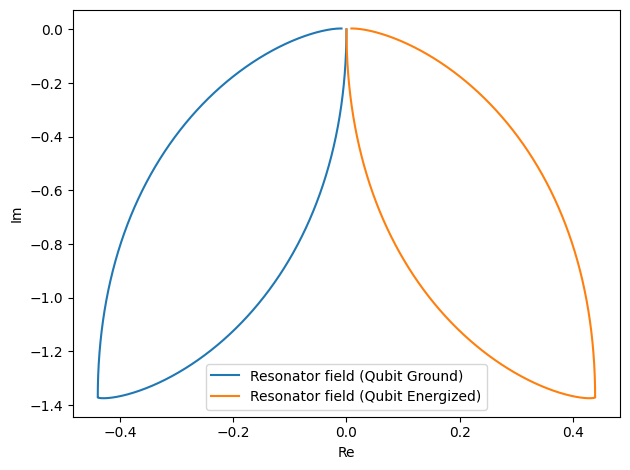

In [5]:
c_ops = [np.sqrt(k) * a]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_g[1]), np.imag(expectation_values_g[1]), label='Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_e[1]), np.imag(expectation_values_e[1]), label='Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

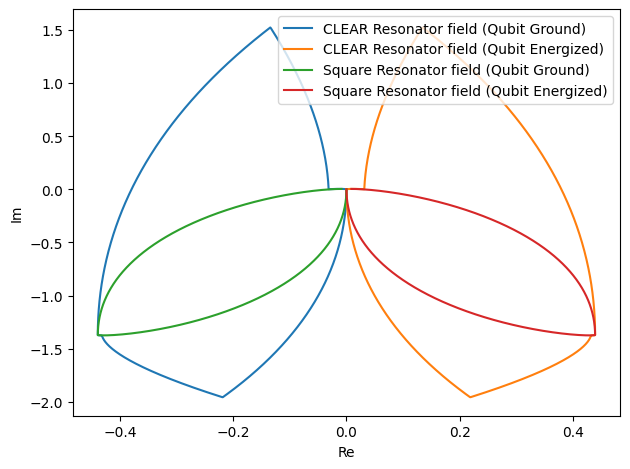

In [6]:
# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR_g = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_CLEAR_e = mesolve(H_CLEAR, psi1, tlist, c_ops, e_ops)
expectations_square_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR_g = [expectations_CLEAR_g.expect[i] for i in range(len(e_ops))]
expectation_values_square_g = [expectations_square_g.expect[i] for i in range(len(e_ops))]
expectation_values_CLEAR_e = [expectations_CLEAR_e.expect[i] for i in range(len(e_ops))]
expectation_values_square_e = [expectations_square_e.expect[i] for i in range(len(e_ops))]


# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_CLEAR_g[1]), np.imag(expectation_values_CLEAR_g[1]), label='CLEAR Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_CLEAR_e[1]), np.imag(expectation_values_CLEAR_e[1]), label='CLEAR Resonator field (Qubit Energized)')
plt.plot(np.real(expectation_values_square_g[1]), np.imag(expectation_values_square_g[1]), label='Square Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_square_e[1]), np.imag(expectation_values_square_e[1]), label='Square Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

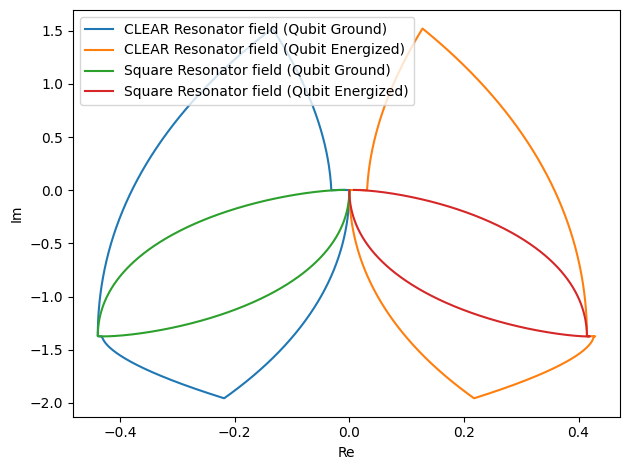

In [12]:
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR_g = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_CLEAR_e = mesolve(H_CLEAR, psi1, tlist, c_ops, e_ops)
expectations_square_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR_g = [expectations_CLEAR_g.expect[i] for i in range(len(e_ops))]
expectation_values_square_g = [expectations_square_g.expect[i] for i in range(len(e_ops))]
expectation_values_CLEAR_e = [expectations_CLEAR_e.expect[i] for i in range(len(e_ops))]
expectation_values_square_e = [expectations_square_e.expect[i] for i in range(len(e_ops))]


# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_CLEAR_g[1]), np.imag(expectation_values_CLEAR_g[1]), label='CLEAR Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_CLEAR_e[1]), np.imag(expectation_values_CLEAR_e[1]), label='CLEAR Resonator field (Qubit Energized)')
plt.plot(np.real(expectation_values_square_g[1]), np.imag(expectation_values_square_g[1]), label='Square Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_square_e[1]), np.imag(expectation_values_square_e[1]), label='Square Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

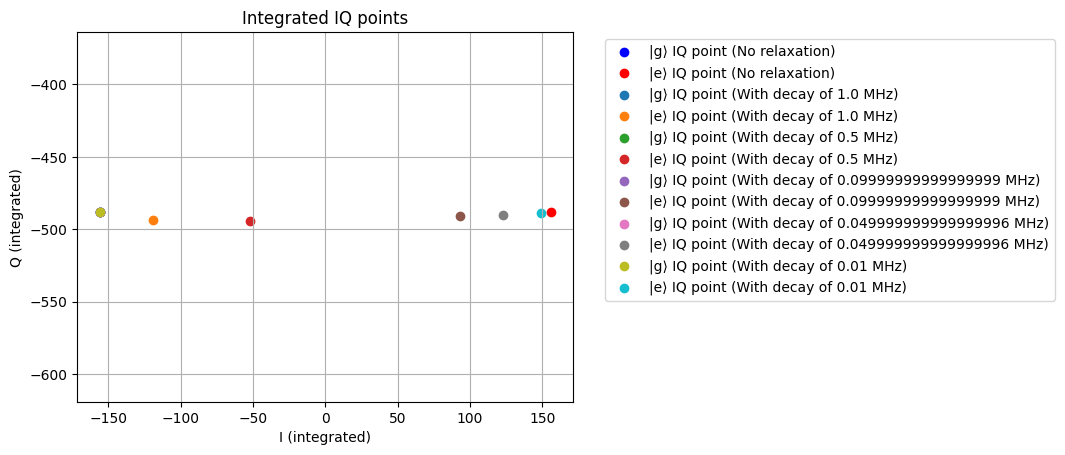

In [30]:
c_ops = [np.sqrt(k) * a]  # Resonator decay and qubit decay
e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points

# Calculate the expectation values of the measurement operators
I_g_norm, Q_g_norm = mesolve(H_drive, psi0, tlist, c_ops, e_ops).expect
I_e_norm, Q_e_norm = mesolve(H_drive, psi1, tlist, c_ops, e_ops).expect

I_g_avg_norm = np.trapezoid(I_g_norm[3220:5000], tlist[3220:5000])
Q_g_avg_norm = np.trapezoid(Q_g_norm[3220:5000], tlist[3220:5000])

I_e_avg_norm = np.trapezoid(I_e_norm[3220:5000], tlist[3220:5000])
Q_e_avg_norm = np.trapezoid(Q_e_norm[3220:5000], tlist[3220:5000])

plt.figure()
plt.scatter(I_g_avg_norm, Q_g_avg_norm, label='|g⟩ IQ point (No relaxation)', color='blue')
plt.scatter(I_e_avg_norm, Q_e_avg_norm, label='|e⟩ IQ point (No relaxation)', color='red')

gammas = [0.001 * 2 * np.pi, 0.0005 * 2 * np.pi, 0.0001 * 2 * np.pi, 0.00005 * 2 * np.pi, 0.00001 * 2 * np.pi]

for gamma in gammas:
    c_ops = [np.sqrt(k) * a, np.sqrt(gamma) * q, np.sqrt(gamma) * sz]  # Resonator decay and qubit decay

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    I_g, Q_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops).expect
    I_e, Q_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops).expect

    I_g_avg = np.trapezoid(I_g[3220:5000], tlist[3220:5000])
    Q_g_avg = np.trapezoid(Q_g[3220:5000], tlist[3220:5000])

    I_e_avg = np.trapezoid(I_e[3220:5000], tlist[3220:5000])
    Q_e_avg = np.trapezoid(Q_e[3220:5000], tlist[3220:5000])

    plt.scatter(I_g_avg, Q_g_avg, label=f'|g⟩ IQ point (With decay of {gamma/(2 * np.pi * 1e-3)} MHz)')
    plt.scatter(I_e_avg, Q_e_avg, label=f'|e⟩ IQ point (With decay of {gamma/(2 * np.pi * 1e-3)} MHz)')


plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("Integrated IQ points")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.grid()
plt.show()

10.0%. Run time: 533.22s. Est. time left: 00:01:19:59
20.0%. Run time: 541.56s. Est. time left: 00:00:36:06
30.0%. Run time: 569.62s. Est. time left: 00:00:22:09
40.0%. Run time: 1024.75s. Est. time left: 00:00:25:37
50.0%. Run time: 1046.66s. Est. time left: 00:00:17:26
60.0%. Run time: 1084.94s. Est. time left: 00:00:12:03
70.0%. Run time: 1515.58s. Est. time left: 00:00:10:49
80.0%. Run time: 1531.85s. Est. time left: 00:00:06:22
90.0%. Run time: 1555.89s. Est. time left: 00:00:02:52
100.0%. Run time: 1683.69s. Est. time left: 00:00:00:00
Total run time: 1683.72s
10.0%. Run time: 526.77s. Est. time left: 00:01:19:00
20.0%. Run time: 536.95s. Est. time left: 00:00:35:47
30.0%. Run time: 550.24s. Est. time left: 00:00:21:23
40.0%. Run time: 1030.52s. Est. time left: 00:00:25:45
50.0%. Run time: 1057.54s. Est. time left: 00:00:17:37
60.0%. Run time: 1077.96s. Est. time left: 00:00:11:58
70.0%. Run time: 1528.87s. Est. time left: 00:00:10:55
80.0%. Run time: 1552.12s. Est. time left: 00

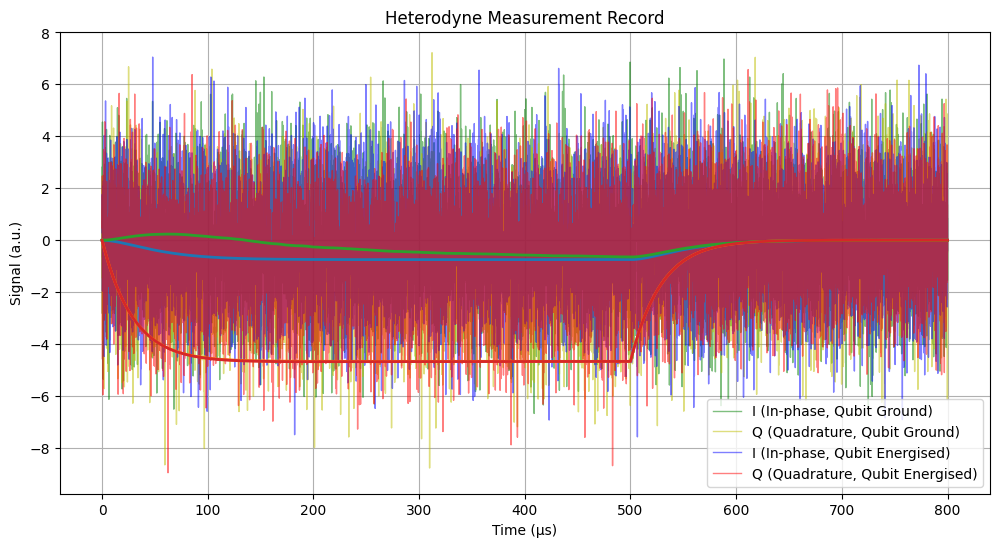

In [35]:
ntrajs = 50

e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_drive,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

result_e = smesolve(
    H_drive,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

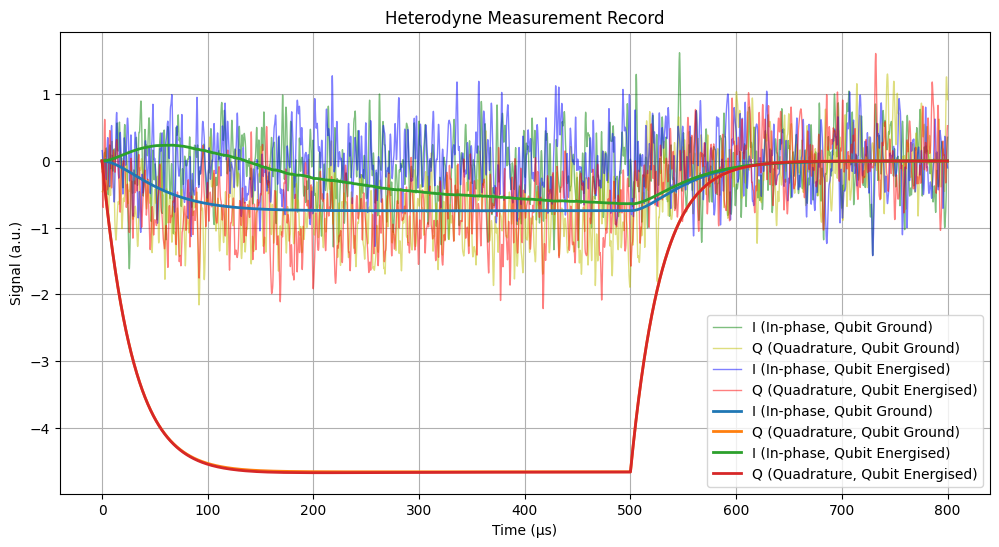

In [36]:
from scipy.ndimage import gaussian_filter1d

I_g = np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_g = np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)
I_e = np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_e = np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)

I_g_filtered = gaussian_filter1d(I_g, sigma=6)
Q_g_filtered = gaussian_filter1d(Q_g, sigma=6)
I_e_filtered = gaussian_filter1d(I_e, sigma=6)
Q_e_filtered = gaussian_filter1d(Q_e, sigma=6)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], I_g_filtered, "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], Q_g_filtered, "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], I_e_filtered, "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], Q_e_filtered, "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Ground)')
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Energised)')
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Energised)')

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.5700
SNR of readout: 0.42


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


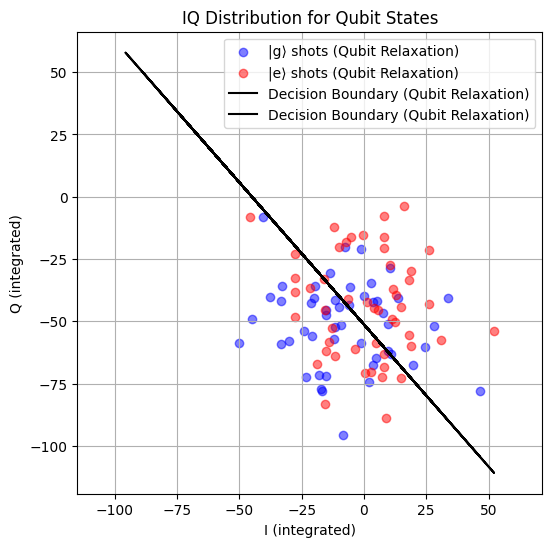

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 3220:5000]
    Q = m[0, 1, 3220:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 3220:5000]
    Q = m[0, 1, 3220:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

10.0%. Run time: 505.66s. Est. time left: 00:01:15:50
20.0%. Run time: 517.83s. Est. time left: 00:00:34:31
30.0%. Run time: 530.78s. Est. time left: 00:00:20:38
40.0%. Run time: 1017.59s. Est. time left: 00:00:25:26
50.0%. Run time: 1046.56s. Est. time left: 00:00:17:26
60.0%. Run time: 1079.30s. Est. time left: 00:00:11:59
70.0%. Run time: 1606.25s. Est. time left: 00:00:11:28
80.0%. Run time: 1627.95s. Est. time left: 00:00:06:46
90.0%. Run time: 1640.97s. Est. time left: 00:00:03:02
100.0%. Run time: 1781.62s. Est. time left: 00:00:00:00
Total run time: 1781.67s
10.0%. Run time: 489.56s. Est. time left: 00:01:13:25
20.0%. Run time: 498.69s. Est. time left: 00:00:33:14
30.0%. Run time: 516.67s. Est. time left: 00:00:20:05
40.0%. Run time: 1017.98s. Est. time left: 00:00:25:26
50.0%. Run time: 1033.64s. Est. time left: 00:00:17:13
60.0%. Run time: 1049.26s. Est. time left: 00:00:11:39
70.0%. Run time: 1503.00s. Est. time left: 00:00:10:44
80.0%. Run time: 1536.94s. Est. time left: 00

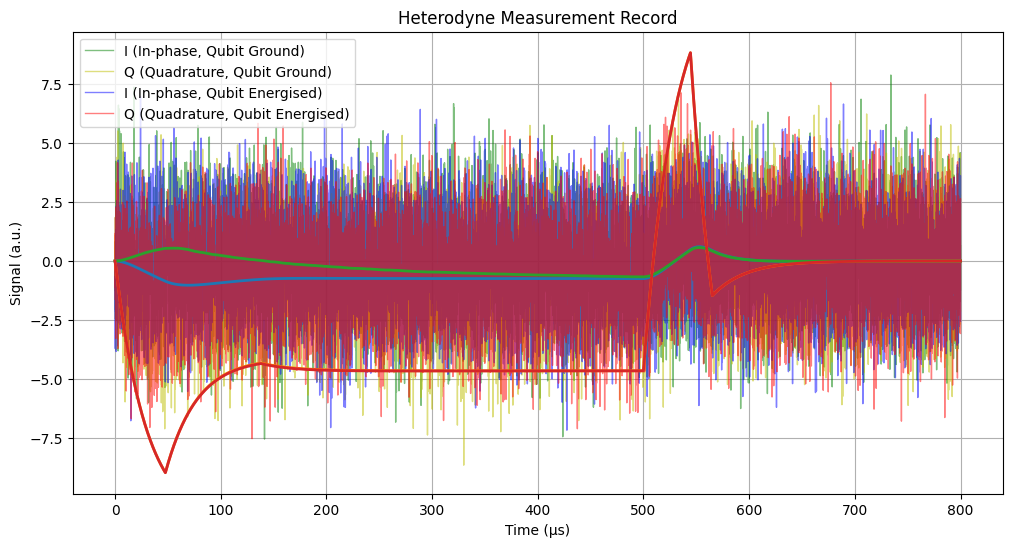

In [16]:
ntrajs = 50

e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_CLEAR,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

result_e = smesolve(
    H_CLEAR,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

qsave(result_g, 'result_g_decay')
qsave(result_e, 'result_e_decay')

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

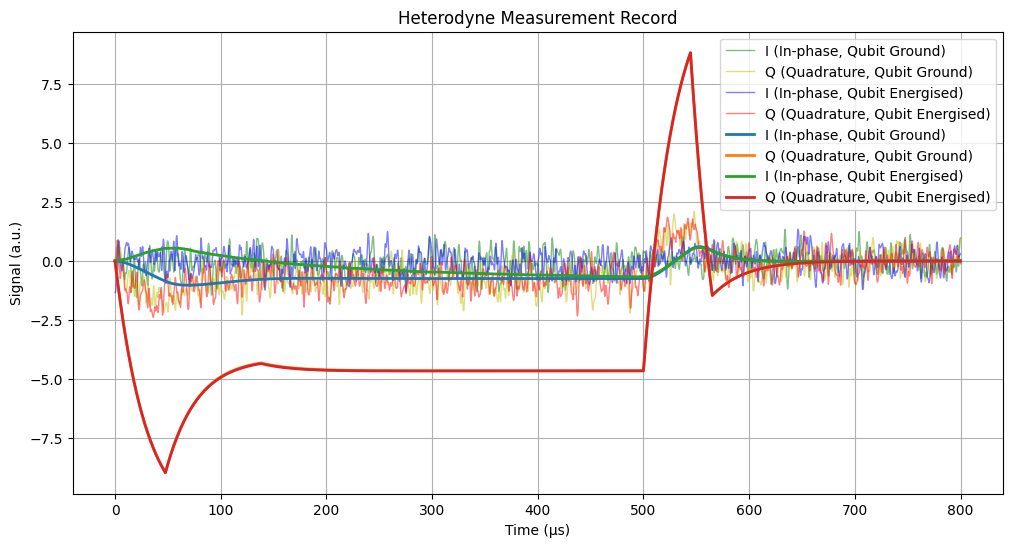

In [17]:
from scipy.ndimage import gaussian_filter1d

I_g = np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_g = np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)
I_e = np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_e = np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)

I_g_filtered = gaussian_filter1d(I_g, sigma=6)
Q_g_filtered = gaussian_filter1d(Q_g, sigma=6)
I_e_filtered = gaussian_filter1d(I_e, sigma=6)
Q_e_filtered = gaussian_filter1d(Q_e, sigma=6)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], I_g_filtered, "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], Q_g_filtered, "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], I_e_filtered, "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], Q_e_filtered, "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Ground)')
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Energised)')
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Energised)')

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.5900
SNR of readout: 0.03


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


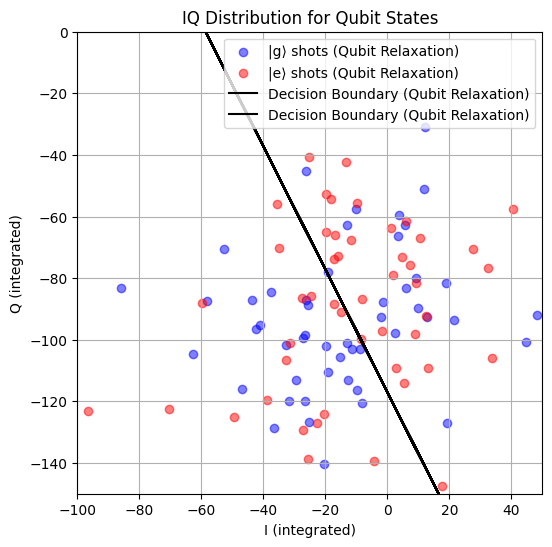

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(-150,0)
plt.xlim(-100,50)
plt.show()

10.0%. Run time: 417.12s. Est. time left: 00:01:02:34
20.0%. Run time: 420.11s. Est. time left: 00:00:28:00
30.0%. Run time: 427.41s. Est. time left: 00:00:16:37
40.0%. Run time: 811.07s. Est. time left: 00:00:20:16
50.0%. Run time: 818.79s. Est. time left: 00:00:13:38
60.0%. Run time: 828.84s. Est. time left: 00:00:09:12
70.0%. Run time: 1187.88s. Est. time left: 00:00:08:29
80.0%. Run time: 1193.34s. Est. time left: 00:00:04:58
90.0%. Run time: 1202.08s. Est. time left: 00:00:02:13
100.0%. Run time: 1331.81s. Est. time left: 00:00:00:00
Total run time: 1331.85s
10.0%. Run time: 373.36s. Est. time left: 00:00:56:00
20.0%. Run time: 377.36s. Est. time left: 00:00:25:09
30.0%. Run time: 380.78s. Est. time left: 00:00:14:48
40.0%. Run time: 752.16s. Est. time left: 00:00:18:48
50.0%. Run time: 757.03s. Est. time left: 00:00:12:37
60.0%. Run time: 762.01s. Est. time left: 00:00:08:28
70.0%. Run time: 1138.32s. Est. time left: 00:00:08:07
80.0%. Run time: 1148.84s. Est. time left: 00:00:04

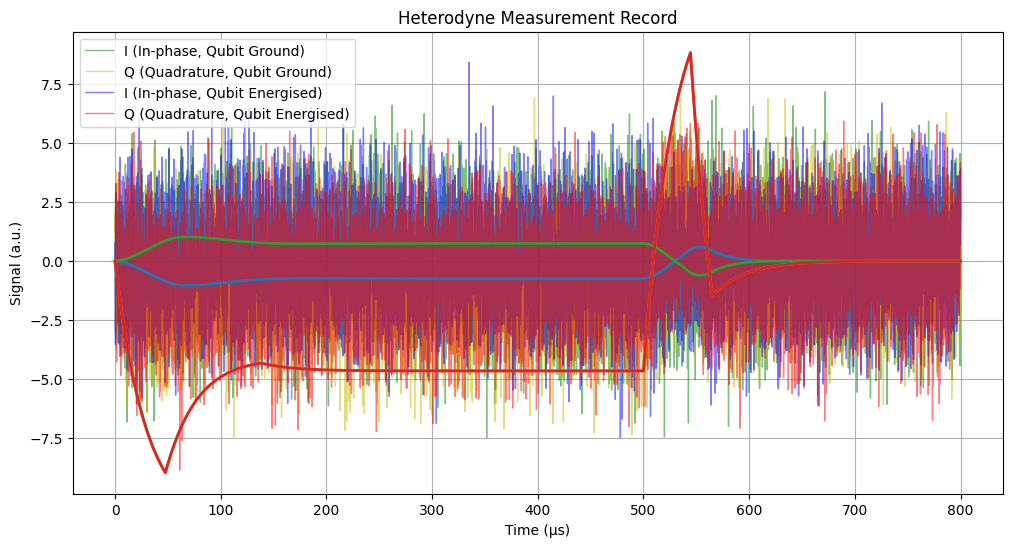

In [45]:
ntrajs = 50
gamma_1 = 0.0 * 2 * np.pi   # No Qubit decay 
gamma_2 = 0.0 * 2 * np.pi   # No Qubit dephase  


e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_CLEAR,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

result_e = smesolve(
    H_CLEAR,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

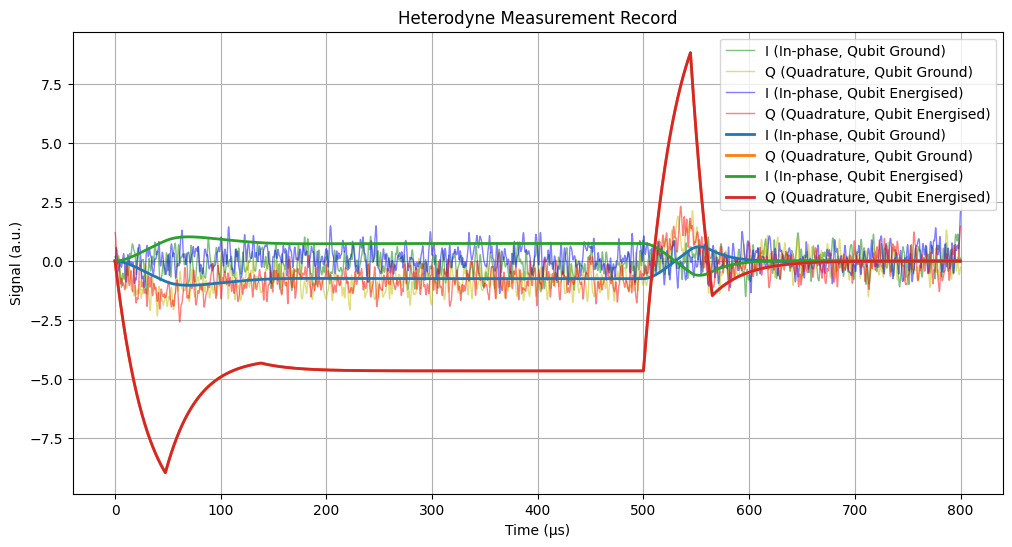

In [48]:
from scipy.ndimage import gaussian_filter1d

I_g = np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_g = np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)
I_e = np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_e = np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)

I_g_filtered = gaussian_filter1d(I_g, sigma=6)
Q_g_filtered = gaussian_filter1d(Q_g, sigma=6)
I_e_filtered = gaussian_filter1d(I_e, sigma=6)
Q_e_filtered = gaussian_filter1d(Q_e, sigma=6)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], I_g_filtered, "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], Q_g_filtered, "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], I_e_filtered, "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], Q_e_filtered, "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Ground)')
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Energised)')
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Energised)')

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.7700
SNR of readout: 1.86


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


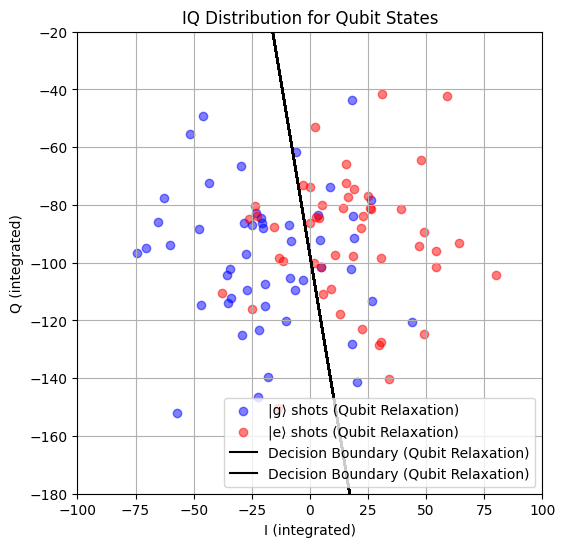

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(-180,-20)
plt.xlim(-100,100)
plt.show()

10.0%. Run time: 418.82s. Est. time left: 00:01:02:49
20.0%. Run time: 423.95s. Est. time left: 00:00:28:15
30.0%. Run time: 431.77s. Est. time left: 00:00:16:47
40.0%. Run time: 834.04s. Est. time left: 00:00:20:51
50.0%. Run time: 844.44s. Est. time left: 00:00:14:04
60.0%. Run time: 853.75s. Est. time left: 00:00:09:29
70.0%. Run time: 1232.63s. Est. time left: 00:00:08:48
80.0%. Run time: 1242.26s. Est. time left: 00:00:05:10
90.0%. Run time: 1253.27s. Est. time left: 00:00:02:19
100.0%. Run time: 1389.85s. Est. time left: 00:00:00:00
Total run time: 1389.87s
10.0%. Run time: 422.80s. Est. time left: 00:01:03:25
20.0%. Run time: 431.86s. Est. time left: 00:00:28:47
30.0%. Run time: 444.76s. Est. time left: 00:00:17:17
40.0%. Run time: 820.79s. Est. time left: 00:00:20:31
50.0%. Run time: 838.25s. Est. time left: 00:00:13:58
60.0%. Run time: 857.68s. Est. time left: 00:00:09:31
70.0%. Run time: 1227.70s. Est. time left: 00:00:08:46
80.0%. Run time: 1240.38s. Est. time left: 00:00:05

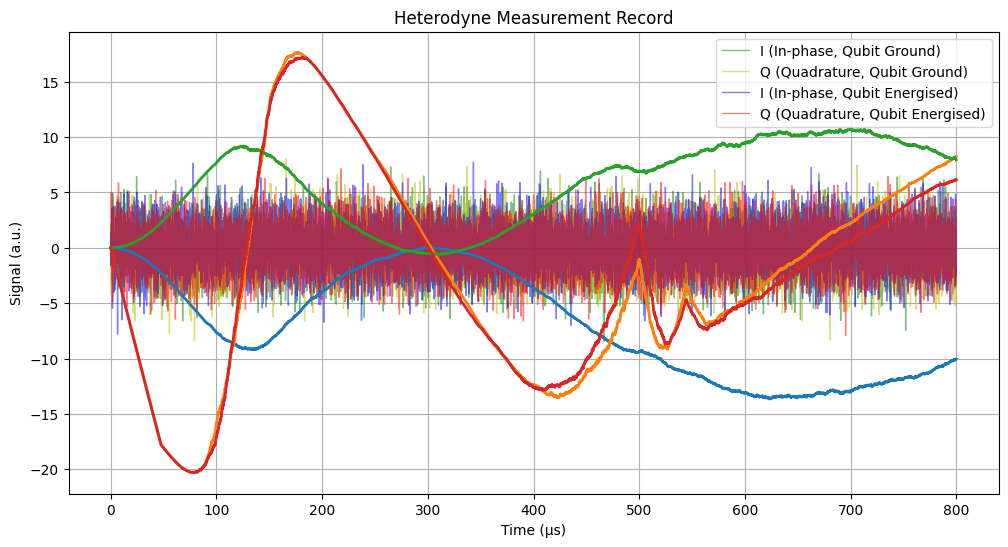

In [4]:
ntrajs = 50
k = 0.0000535 * 2 * np.pi
gamma_1 = 0.0 * 2 * np.pi   # No Qubit decay 
gamma_2 = 0.0 * 2 * np.pi   # No Qubit dephase  


e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_CLEAR,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

result_e = smesolve(
    H_CLEAR,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

qsave(result_g, 'result_g_ideal')
qsave(result_e, 'result_e_ideal')

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

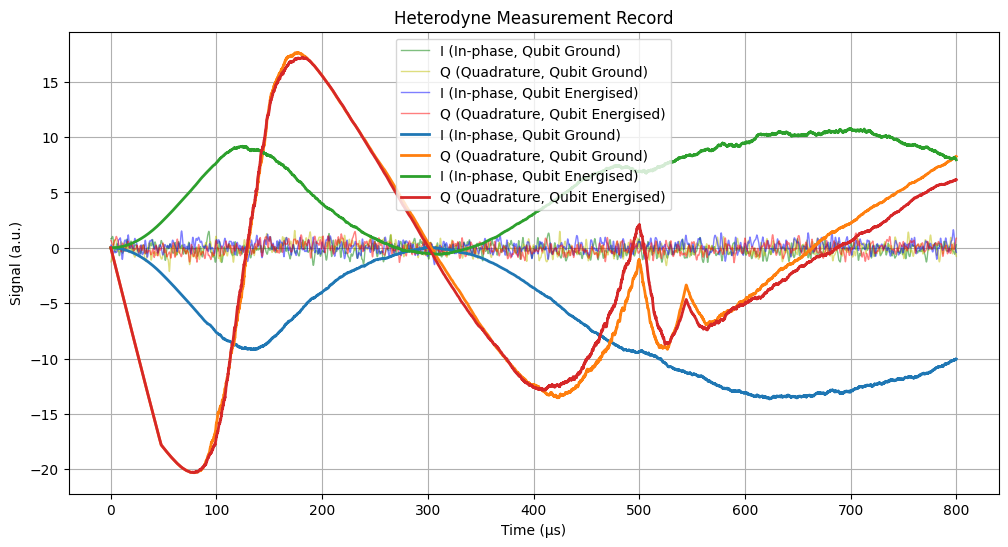

In [5]:
from scipy.ndimage import gaussian_filter1d

I_g = np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_g = np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)
I_e = np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_e = np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)

I_g_filtered = gaussian_filter1d(I_g, sigma=6)
Q_g_filtered = gaussian_filter1d(Q_g, sigma=6)
I_e_filtered = gaussian_filter1d(I_e, sigma=6)
Q_e_filtered = gaussian_filter1d(Q_e, sigma=6)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], I_g_filtered, "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], Q_g_filtered, "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], I_e_filtered, "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], Q_e_filtered, "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Ground)')
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Energised)')
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Energised)')

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.6100
SNR of readout: 0.33


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


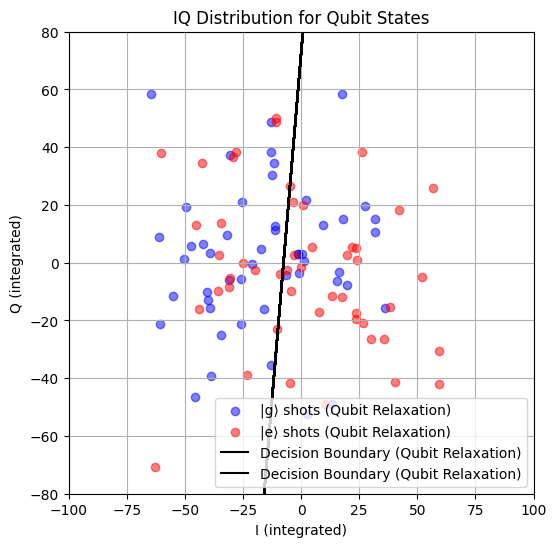

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(-80,80)
plt.xlim(-100,100)
plt.show()

10.0%. Run time: 440.11s. Est. time left: 00:01:06:01
20.0%. Run time: 448.29s. Est. time left: 00:00:29:53
30.0%. Run time: 453.43s. Est. time left: 00:00:17:38
40.0%. Run time: 887.54s. Est. time left: 00:00:22:11
50.0%. Run time: 896.63s. Est. time left: 00:00:14:56
60.0%. Run time: 905.25s. Est. time left: 00:00:10:03
70.0%. Run time: 1327.61s. Est. time left: 00:00:09:28
80.0%. Run time: 1333.69s. Est. time left: 00:00:05:33
90.0%. Run time: 1345.66s. Est. time left: 00:00:02:29
100.0%. Run time: 1485.62s. Est. time left: 00:00:00:00
Total run time: 1485.65s
10.0%. Run time: 436.60s. Est. time left: 00:01:05:29
20.0%. Run time: 444.98s. Est. time left: 00:00:29:39
30.0%. Run time: 454.41s. Est. time left: 00:00:17:40
40.0%. Run time: 892.05s. Est. time left: 00:00:22:18
50.0%. Run time: 908.60s. Est. time left: 00:00:15:08
60.0%. Run time: 928.20s. Est. time left: 00:00:10:18
70.0%. Run time: 1315.18s. Est. time left: 00:00:09:23
80.0%. Run time: 1332.28s. Est. time left: 00:00:05

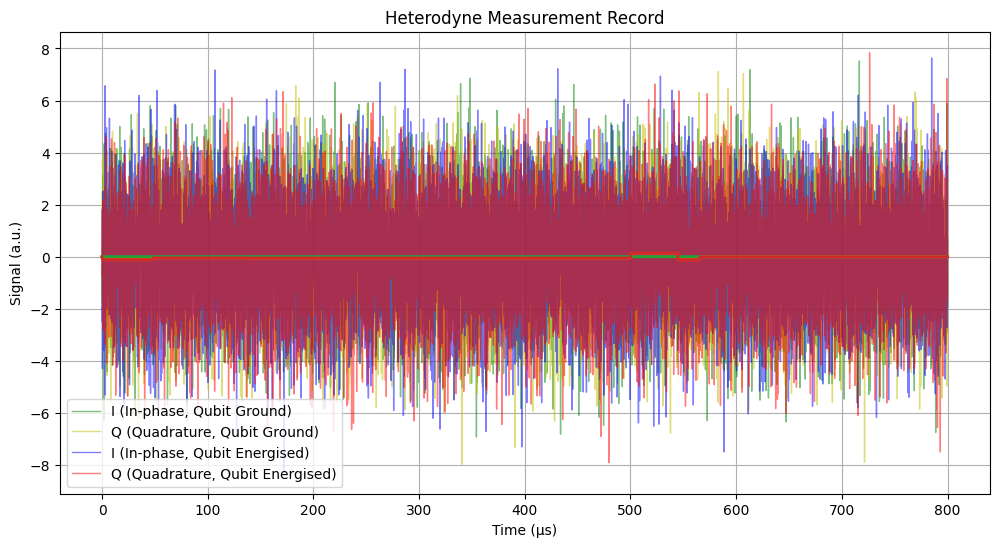

In [12]:
ntrajs = 50
k = 0.535 * 2 * np.pi
gamma_1 = 0.0 * 2 * np.pi   # No Qubit decay 
gamma_2 = 0.0 * 2 * np.pi   # No Qubit dephase  


e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_CLEAR,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

result_e = smesolve(
    H_CLEAR,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel"}
)

qsave(result_g, 'result_g_ideal_highk')
qsave(result_e, 'result_e_ideal_highk')

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

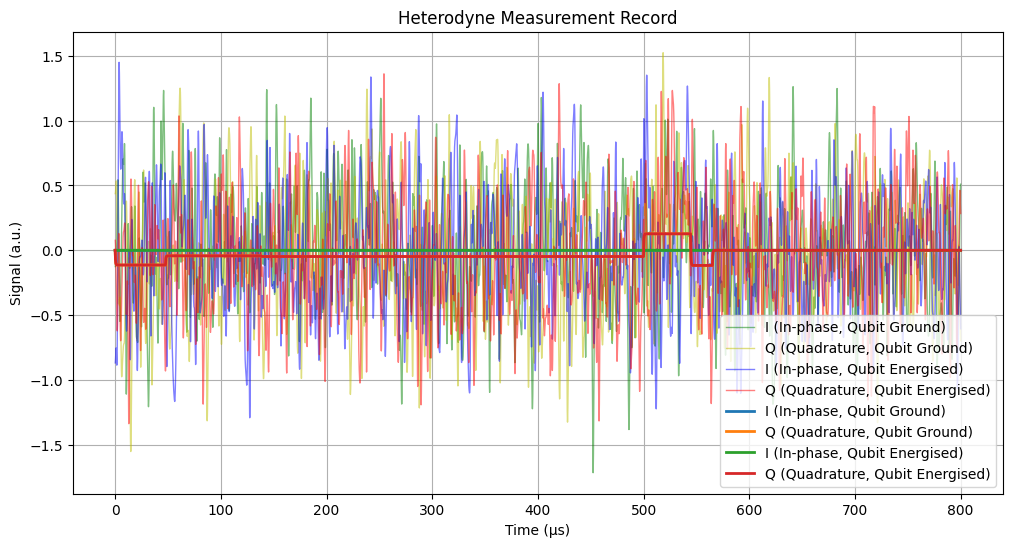

In [13]:
from scipy.ndimage import gaussian_filter1d

I_g = np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_g = np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)
I_e = np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt)
Q_e = np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt)

I_g_filtered = gaussian_filter1d(I_g, sigma=6)
Q_g_filtered = gaussian_filter1d(Q_g, sigma=6)
I_e_filtered = gaussian_filter1d(I_e, sigma=6)
Q_e_filtered = gaussian_filter1d(Q_e, sigma=6)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], I_g_filtered, "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], Q_g_filtered, "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], I_e_filtered, "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], Q_e_filtered, "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Ground)')
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2, label='I (In-phase, Qubit Energised)')
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2, label='Q (Quadrature, Qubit Energised)')

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.5700
SNR of readout: 0.11


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


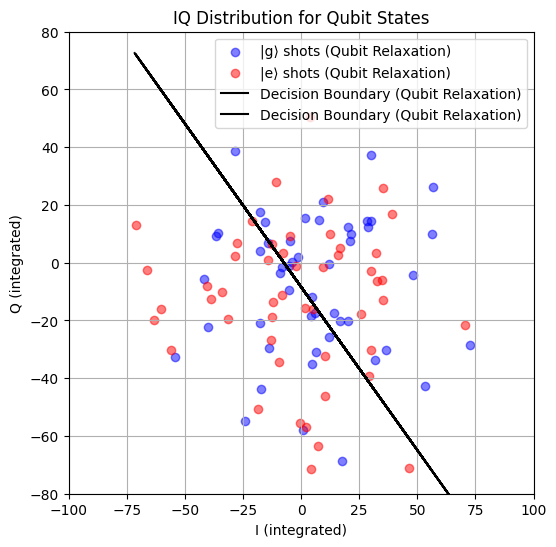

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(-80,80)
plt.xlim(-100,100)
plt.show()

 Total run time: 17457.00s Elapsed 17456.95s / Remaining 00:00:00:00
 Total run time: 17151.99s Elapsed 17151.93s / Remaining 00:00:00:00


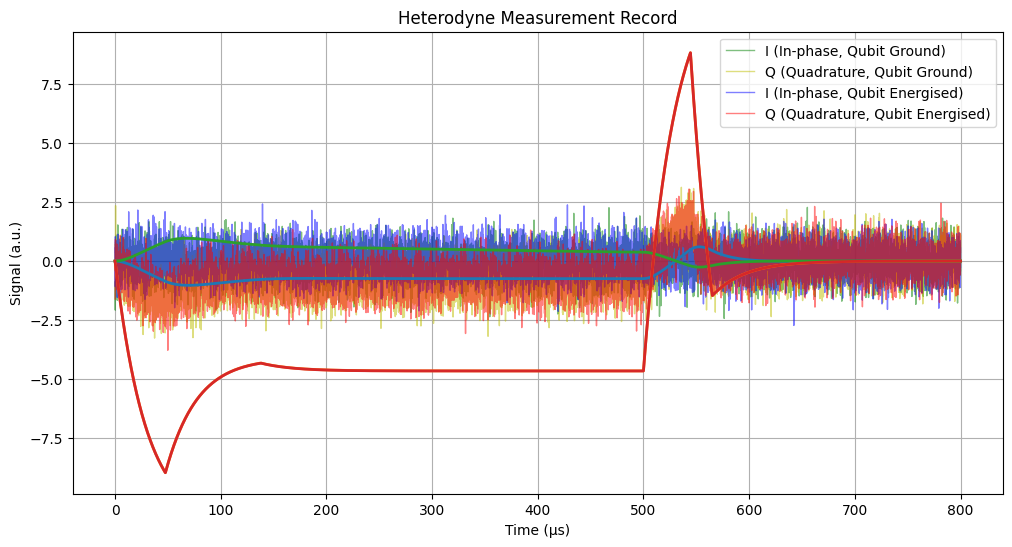

In [ ]:
ntrajs = 500
e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay
sc_ops = [np.sqrt(k) * a] # Measuring the channel of the resonator field

tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
dt = tlist[1] - tlist[0]

# Simulate a single heterodyne measurement trajectory
result_g = smesolve(
    H_CLEAR,
    psi0,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel", 'progress_bar':'enhanced'}
)

result_e = smesolve(
    H_CLEAR,
    psi1,
    tlist,
    ntraj=ntrajs,
    c_ops=c_ops,
    e_ops=e_ops,
    sc_ops=sc_ops,  # heterodyne detection
    heterodyne=True,
    options={'store_measurement':True, "map": "parallel", 'progress_bar':'enhanced'}
)

plt.figure(figsize=(12, 6))

plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "g", lw=1, alpha=0.5, label='I (In-phase, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_g.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "y", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Ground)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 0, :].real/ np.sqrt(dt), "b", lw=1, alpha=0.5, label='I (In-phase, Qubit Energised)')
plt.plot(tlist[1:], np.mean(result_e.measurement, axis=0)[0, 1, :].real/ np.sqrt(dt), "r", lw=1, alpha=0.5, label='Q (Quadrature, Qubit Energised)')

plt.plot(tlist, result_g.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_g.expect[1]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[0]/ np.sqrt(dt), lw=2)
plt.plot(tlist, result_e.expect[1]/ np.sqrt(dt), lw=2)

plt.xlabel("Time (μs)")
plt.ylabel("Signal (a.u.)")
plt.title("Heterodyne Measurement Record")
plt.legend()
plt.grid(True)
plt.show()

Readout fidelity (Qubit Relaxation): 0.6750
SNR of readout: 0.95


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


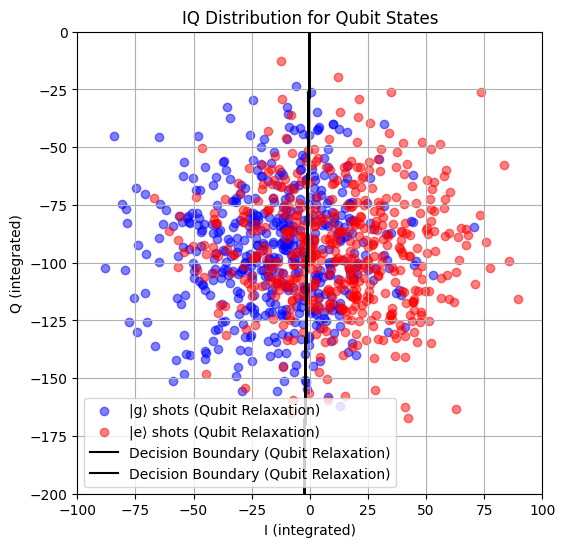

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

I_g = list()
Q_g = list()
I_e = list()
Q_e = list()

for m in result_g.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_g.append(I_int)
    Q_g.append(Q_int)

for m in result_e.measurement:
    I = m[0, 0, 1500:5000]
    Q = m[0, 1, 1500:5000]
    I_int = np.sum(I) * dt
    Q_int = np.sum(Q) * dt
    I_e.append(I_int)
    Q_e.append(Q_int)

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all.real, labels)
preds = lda.predict(IQ_all.real)

coef = lda.coef_[0]      # [w1, w2]
intercept = lda.intercept_[0]  # w0

w1, w2 = coef
y_vals = -(intercept + w1 * IQ_all) / w2

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity (Qubit Relaxation): {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots (Qubit Relaxation)')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots (Qubit Relaxation)')
plt.plot(IQ_all, y_vals, 'k', label='Decision Boundary (Qubit Relaxation)')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.ylim(-200,0)
plt.xlim(-100,100)

plt.show()

In [103]:
ntrajs = 20
e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma_1) * q, np.sqrt(gamma_2) * sz]  # Resonator decay and qubit decay

def estimate_qnd_violation(psi0, label):
    pop_g = []
    for _ in range(ntrajs):
        traj = mcsolve(H_drive, psi0, tlist, c_ops, [], ntraj=1)
        final_state = traj.states[-1]
        rho = final_state.ptrace(1)  # trace out resonator
        p_g = expect(basis(2, 0) * basis(2, 0).dag(), rho)
        pop_g.append(p_g)
    return np.mean(pop_g)

p_g_after_g = estimate_qnd_violation(psi0, '|g⟩ init')
p_g_after_e = estimate_qnd_violation(psi1, '|e⟩ init')
print(f"Qubit remains in |g⟩ after measurement (started in |g⟩): {p_g_after_g:.4f}")
print(f"Qubit remains in |e⟩ after measurement (started in |e⟩): {1 - p_g_after_e:.4f}")

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Total run time:   1.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.95s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.33s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.01s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.33s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.97s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.99s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.33s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.98s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.99s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.98s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.98s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.28s
100.0%. Run time:   0.00s. E

### Repeated Readouts

In [8]:
def drive_pulse(t, args):
    return drive_amp if (t >= 50 and t <= 350) or (t >= 400 and t <= 850) or (t >= 950 and t <= 1200) else 0  # Pulse from 100 ns to 200 ns

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]

tlist = np.linspace(0, 1400, 8000)  # Time from 0 to 800 ns


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


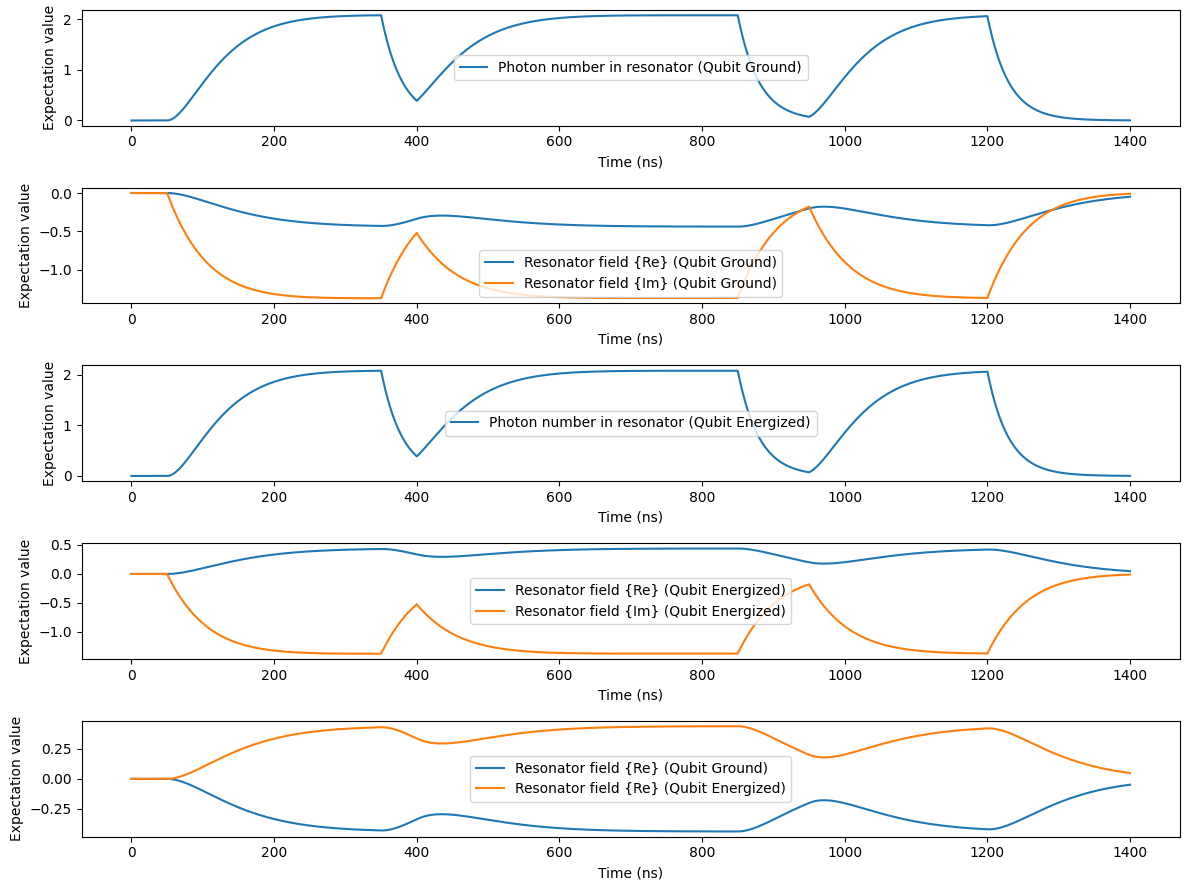

In [9]:
expectations_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(5, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Demonstrate impacts of improper reset on readout fidelity 

### Simulating resonator phase response (behaves as a filter)

/tmp/ipykernel_46309/130137954.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


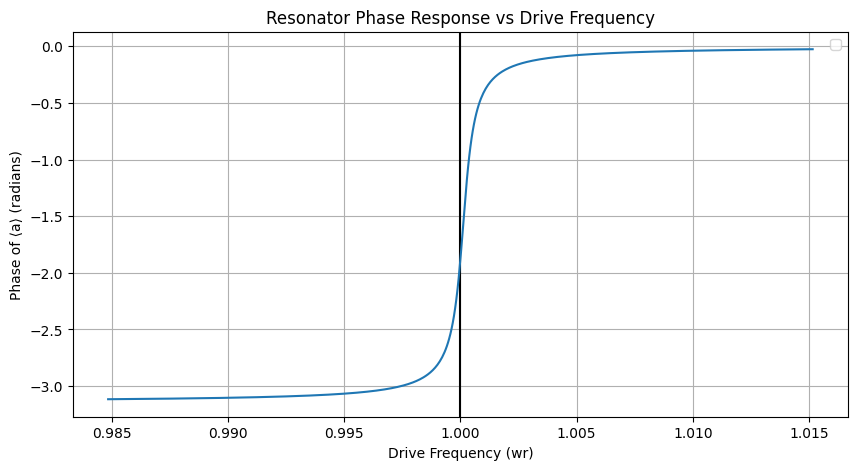

In [15]:
w_d_list = np.linspace(wr - 20*k, wr + 20*k, 600)
a_expect = []

for w_d in w_d_list:
    H0 = (wr - w_d + chi * sz) * a.dag() * a + (wq)/2 * sz
    HD = np.sqrt(drive_power) * (a + a.dag())
    H = H0 + HD
    # Calculate the steady state
    rho_ss_0 = steadystate(H, c_ops=c_ops)
    a_expect.append(expect(a, rho_ss_0))

phase_0 = np.angle(a_expect)

plt.figure(figsize=(10, 5))
plt.axvline(x=1, color='black')
plt.plot(w_d_list / wr, phase_0)
plt.xlabel("Drive Frequency (wr)")
plt.ylabel("Phase of ⟨a⟩ (radians)")
plt.title("Resonator Phase Response vs Drive Frequency")
plt.legend()
plt.grid(True)
plt.show()